## Data Import

In [42]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter, defaultdict
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [43]:
# Load data
df = pd.read_csv('train.csv')

# Show basic info and summary
print("\nDataFrame Shape:")
print(df.shape)

print("\nDataFrame Info:")
print(df.info())

print("\nFirst few rows:")
print(df.head())

print("\nSummary stats:")
print(df.describe())



DataFrame Shape:
(114000, 21)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  11

## Data Exploration

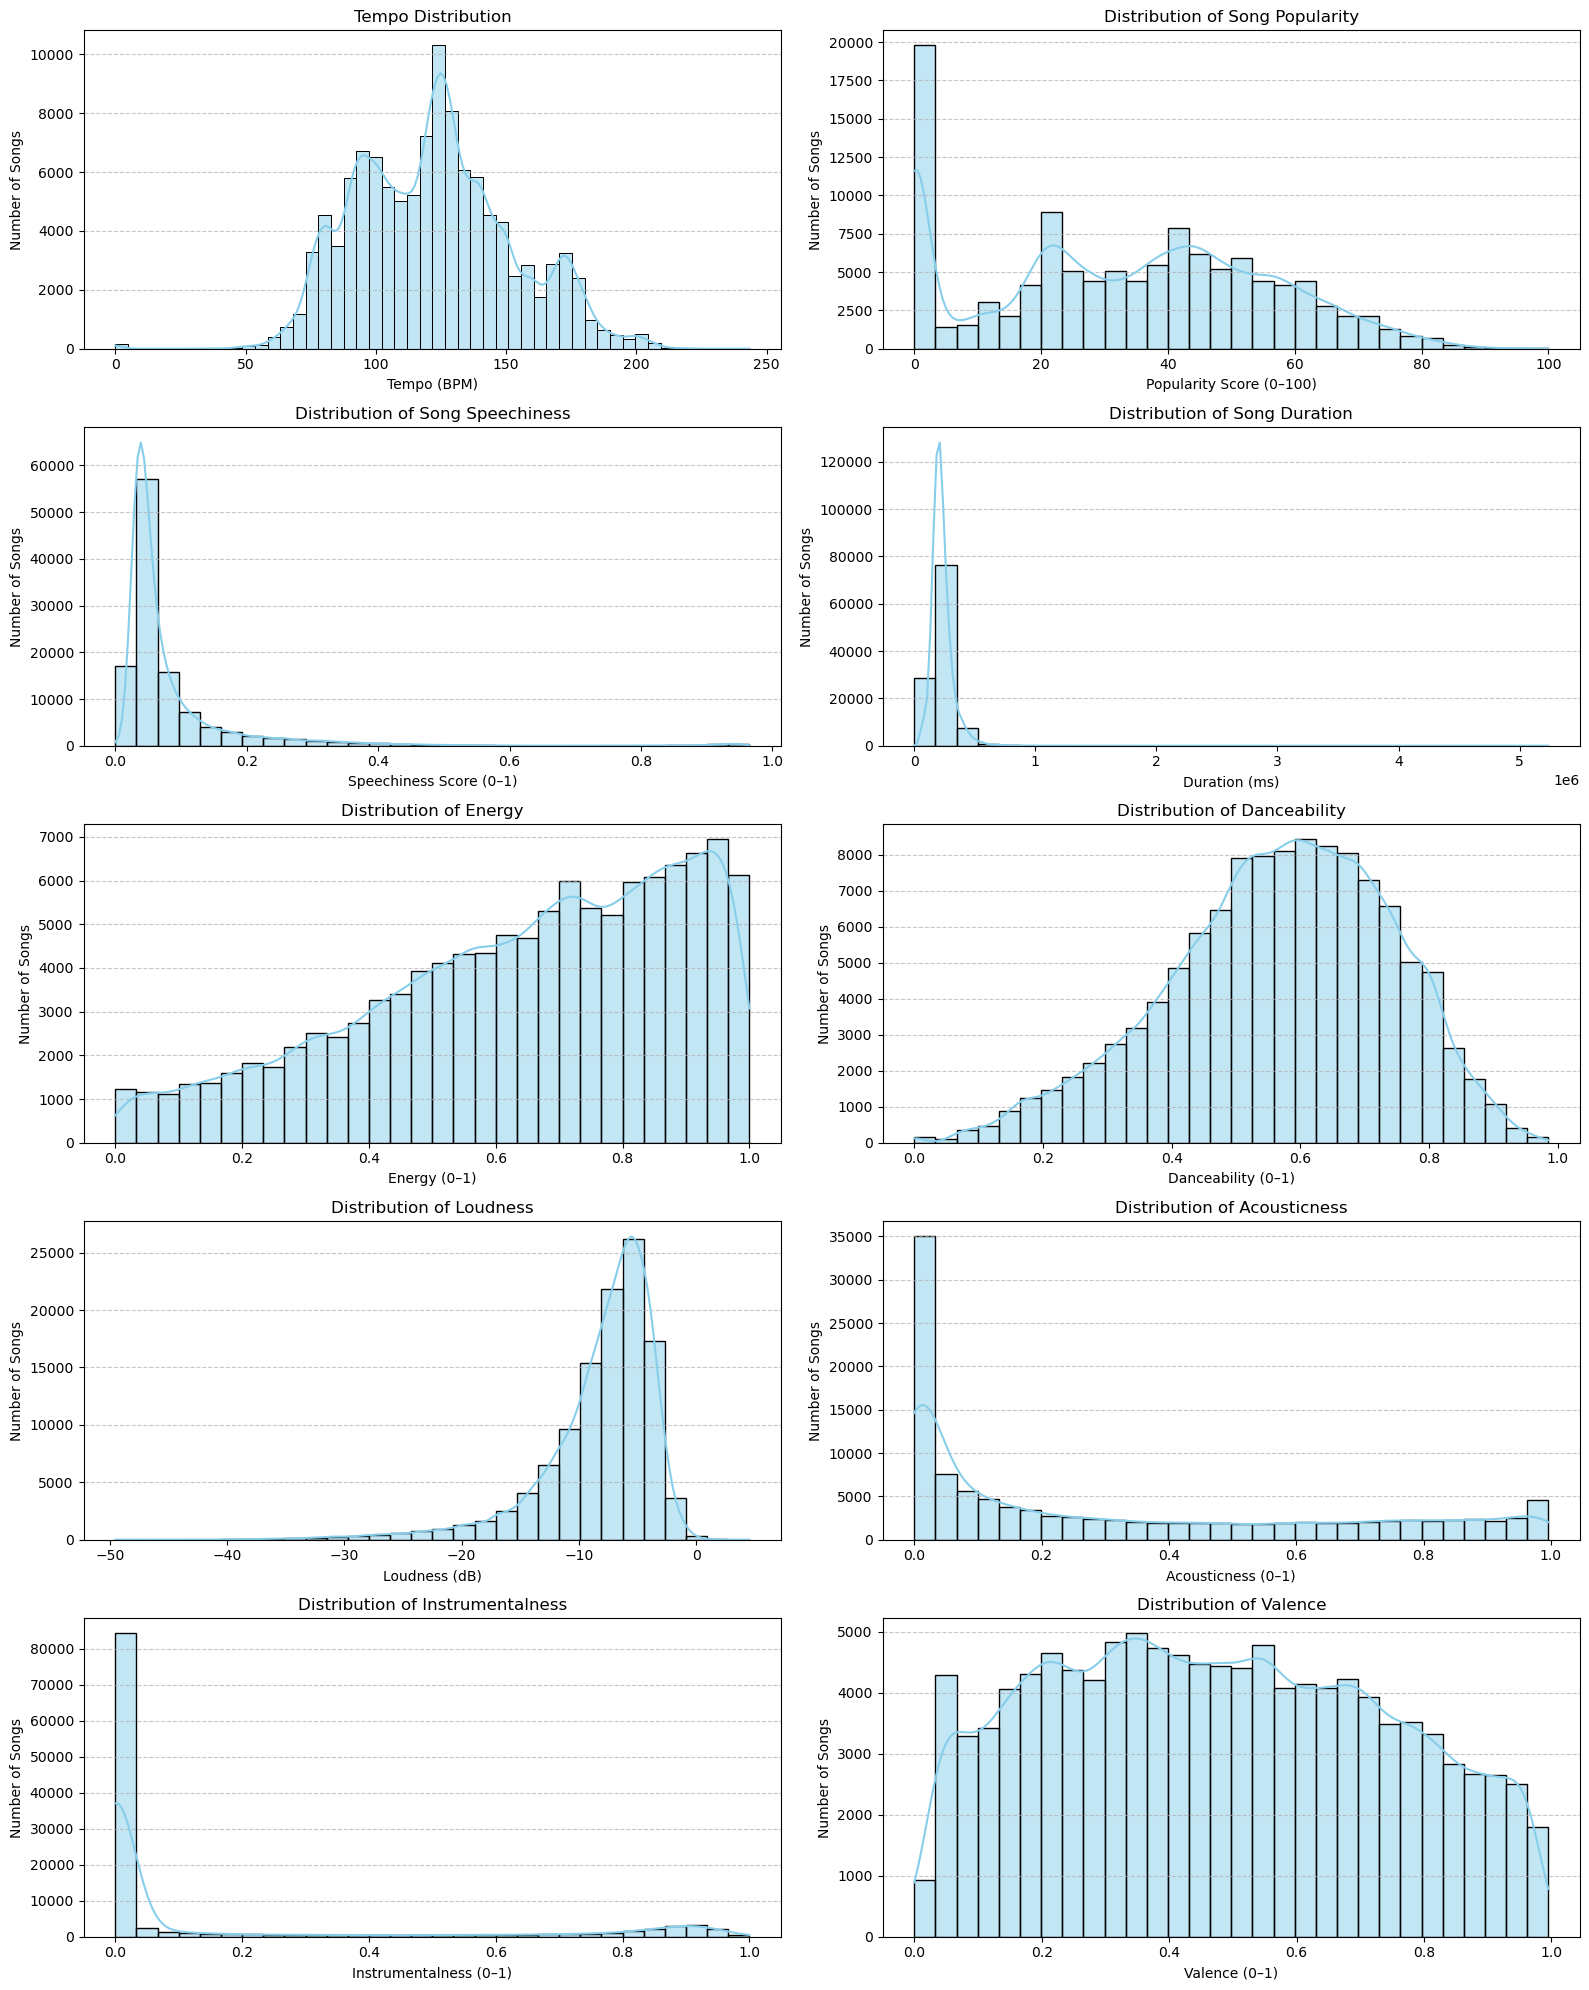

In [44]:
# Plot key quantitative features
def plot_hist(ax, data, column, title, xlabel, bins=30, color='skyblue'):
    sns.histplot(data[column], bins=bins, kde=True, color=color, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Number of Songs')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Create 5x2 grid
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

# Define plots
plot_configs = [
    ('tempo', 'Tempo Distribution', 'Tempo (BPM)', 50),
    ('popularity', 'Distribution of Song Popularity', 'Popularity Score (0–100)', 30),
    ('speechiness', 'Distribution of Song Speechiness', 'Speechiness Score (0–1)', 30),
    ('duration_ms', 'Distribution of Song Duration', 'Duration (ms)', 30),
    ('energy', 'Distribution of Energy', 'Energy (0–1)', 30),
    ('danceability', 'Distribution of Danceability', 'Danceability (0–1)', 30),
    ('loudness', 'Distribution of Loudness', 'Loudness (dB)', 30),
    ('acousticness', 'Distribution of Acousticness', 'Acousticness (0–1)', 30),
    ('instrumentalness', 'Distribution of Instrumentalness', 'Instrumentalness (0–1)', 30),
    ('valence', 'Distribution of Valence', 'Valence (0–1)', 30),
]

# Plot all charts
for ax, (col, title, xlabel, bins) in zip(axes, plot_configs):
    plot_hist(ax, df, col, title, xlabel, bins=bins)

# Layout
plt.tight_layout()
plt.show()


In [45]:
# Convert duration_ms to MM:SS format
df['duration_MM_SS'] = df['duration_ms'].apply(lambda x: f"{int(x // 60000):02}:{int((x % 60000) // 1000):02}")

df['duration_MM_SS'].head()

0    03:50
1    02:29
2    03:30
3    03:21
4    03:18
Name: duration_MM_SS, dtype: object

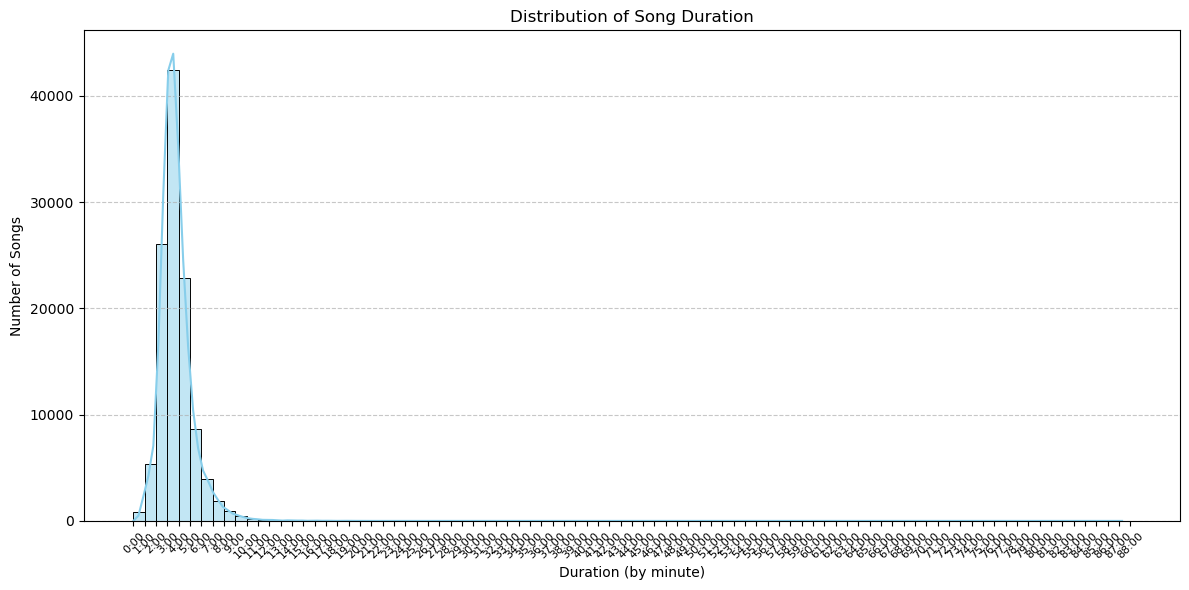

In [46]:
# Distribution of Duration
# Convert duration_ms to seconds
df['duration_sec'] = df['duration_ms'] // 1000

# Create bins of 30-second intervals
bin_width = 60
max_duration = df['duration_sec'].max()
bins = range(0, int(max_duration + bin_width), bin_width)

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(df['duration_sec'], bins=bins, kde=True, color='skyblue')

plt.title('Distribution of Song Duration')
plt.xlabel('Duration (by minute)')
plt.ylabel('Number of Songs')
plt.xticks(ticks=bins, labels=[f"{int(b//60)}:{int(b%60):02}" for b in bins], rotation=45, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

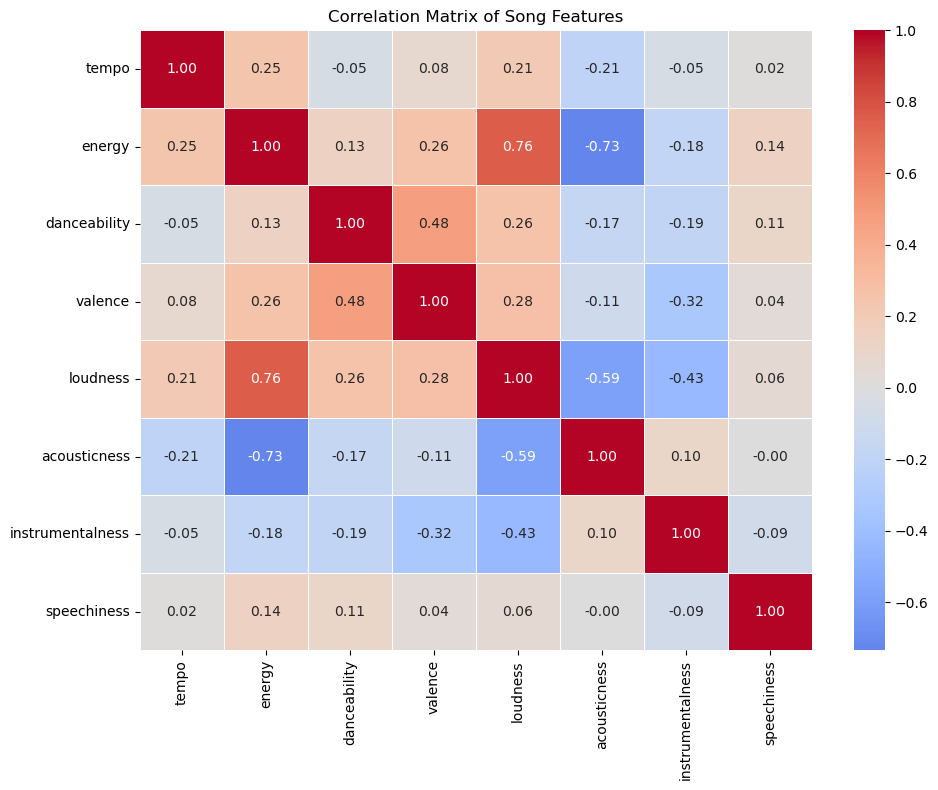

In [47]:
# Correlation Matrix
numeric_features = ['tempo', 'energy', 'danceability', 'valence', 'loudness',
                    'acousticness', 'instrumentalness', 'speechiness']

# Compute correlation matrix
corr_matrix = df[numeric_features].corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Song Features')
plt.tight_layout()
plt.show()


In [48]:
# Top Artists
def parse_artists(val):
    if isinstance(val, str):
        return [artist.strip() for artist in val.split(';')]
    return []

# Apply parser
artist_lists = df['artists'].dropna().apply(parse_artists)

# Flatten and count
flat_artists = [artist for sublist in artist_lists for artist in sublist]
artist_counts = Counter(flat_artists)
top_artists = artist_counts.most_common(10)

# Display results
print("Top 10 Most Common Artists:")
for i, (artist, count) in enumerate(top_artists, 1):
    print(f"{i}. {artist}: {count} songs")


Top 10 Most Common Artists:
1. J Balvin: 510 songs
2. Bad Bunny: 416 songs
3. Daddy Yankee: 375 songs
4. Wolfgang Amadeus Mozart: 354 songs
5. Feid: 348 songs
6. George Jones: 343 songs
7. Pritam: 333 songs
8. Arijit Singh: 305 songs
9. ILLENIUM: 298 songs
10. The Beatles: 280 songs


In [49]:
# Check numeric features by artists
# Parse artists using the current format
def parse_artists(val):
    if isinstance(val, str):
        return [artist.strip() for artist in val.split(';')]
    return []

# Apply 
df_copy = df.copy()
df_copy['artists_list'] = df_copy['artists'].apply(parse_artists)
df_exploded = df_copy.explode('artists_list')

# Filter to top 10 artists
top_10_names = [artist for artist, _ in top_artists]
filtered = df_exploded[df_exploded['artists_list'].isin(top_10_names)]

# Group and summarize by tempo, energy, and danceability
artist_stats = filtered.groupby('artists_list')[['tempo', 'energy', 'danceability']].mean().sort_values(by='tempo', ascending=False)

# Display
print("Average Tempo, Energy, and Danceability for Top 10 Artists:")
print(artist_stats)


Average Tempo, Energy, and Danceability for Top 10 Artists:
                              tempo    energy  danceability
artists_list                                               
Feid                     139.236848  0.637839      0.764468
ILLENIUM                 139.161634  0.720721      0.468138
The Beatles              122.552939  0.540763      0.519114
J Balvin                 122.339737  0.738053      0.767957
Arijit Singh             116.177407  0.592059      0.530426
Pritam                   114.321586  0.711018      0.593760
Daddy Yankee             112.968816  0.835701      0.754843
Wolfgang Amadeus Mozart  111.036588  0.121095      0.411643
Bad Bunny                110.918115  0.691075      0.760397
George Jones             109.318924  0.357306      0.538583


In [50]:
# Top Artist by Genre
# Parse artists into lists
df_copy = df.copy()
df_copy['artists_list'] = df_copy['artists'].apply(parse_artists)

# Explode artists to get one row per artist-track
df_exploded = df_copy.explode('artists_list')

# Group by genre and artist, then count
genre_artist_counts = df_exploded.groupby(['track_genre', 'artists_list']).size().reset_index(name='count')

# For each genre, get top artist(s)
top_artists_by_genre = (
    genre_artist_counts
    .sort_values(['track_genre', 'count'], ascending=[True, False])
    .groupby('track_genre')
    .head(1)
)

# Display
pd.set_option('display.max_rows', None) 
print("Top Artist by Genre:")
display(top_artists_by_genre)


Top Artist by Genre:


track_genre                             artists_list  count
52              acoustic                             Boyce Avenue     45
409             afrobeat                                   Criolo     73
979             alt-rock                    Red Hot Chili Peppers     38
1178         alternative                                    GAYLE     41
1651             ambient                         Ludovico Einaudi     69
1950               anime                                     Kato     56
2280         black-metal                                Hypocrisy     29
2525           bluegrass                       Greensky Bluegrass     56
2799               blues                          Ella Fitzgerald    131
3355              brazil                                   Maneva     31
3950           breakbeat                    The Chemical Brothers     82
4269             british                              The Beatles    127
4507            cantopop                        my little airport    171
4830       chicago-house                             Paul Johnson     61
4973            children                                CoComelon    122
5399               chill                              Pink Sweat$     59
6243           classical                  Wolfgang Amadeus Mozart    354
6392                club                                Glee Cast    171
6804              comedy                         Kathleen Madigan     57
7048             country                          Kacey Musgraves     62
7236               dance                             Charlie Puth     66
7539           dancehall                                Burna Boy    100
8123         death-metal                                   Gojira     31
8954          deep-house                             Robin Schulz     32
9220      detroit-techno                               Inner City     91
9396               disco                                 Bee Gees     33
10084             disney                          Germaine Franco    106
10565      drum-and-bass                           Chase & Status     38
11372                dub                                 ILLENIUM    114
12119            dubstep                                 ILLENIUM    124
12688                edm                             David Guetta     81
13218            electro                            Billie Eilish     47
13807         electronic                                 DJ Snake     68
14788                emo                             XXXTENTACION    100
15096               folk                    Nusrat Fateh Ali Khan     61
15445              forro                   Os Barões Da Pisadinha     72
15752             french                                   Indila     23
16803               funk                            Stevie Wonder     85
16883             garage                           Arctic Monkeys    109
17468             german                              Hans Zimmer    176
17956             gospel                              Fernandinho     42
18266               goth                          Håkan Hellström    141
18519          grindcore                             Napalm Death     88
18792             groove                                   Kemuel     51
19143             grunge                              Linkin Park    151
19430             guitar                          Little Symphony     59
19883              happy                                  Scooter    140
19986          hard-rock                        Charlie Brown Jr.    110
20484           hardcore                          Los Prisioneros     41
21218          hardstyle                              The Prophet     68
21276        heavy-metal                               Almafuerte     99
21418            hip-hop                      Anirudh Ravichander     82
21881         honky-tonk                             George Jones    343
21952              house                              Alan Walker     4

## Feature Engineering

In [51]:
# Create new 'spin genre' feature
spin_genre_map = {
    # Pop/EDM/Electronic
    'pop': 'pop/edm',
    'dance': 'pop/edm',
    'edm': 'pop/edm',
    'club': 'pop/edm',
    'house': 'pop/edm',
    'deep-house': 'pop/edm',
    'electro': 'pop/edm',
    'electronic': 'pop/edm',
    'progressive-house': 'pop/edm',
    'synth-pop': 'pop/edm',
    'trance': 'pop/edm',
    'disco': 'pop/edm',
    'party': 'pop/edm',
    'techno': 'pop/edm',
    'garage': 'pop/edm',
    'detroit-techno': 'pop/edm',
    'minimal-techno': 'pop/edm',
    'breakbeat': 'pop/edm',
    'drum-and-bass': 'pop/edm',
    'dubstep': 'pop/edm',
    'trip-hop': 'pop/edm',
    'idm': 'pop/edm',
    'british': 'pop/edm',
    'chicago-house': 'pop/edm',
    'dub': 'pop/edm',
    'garage': 'pop/edm',

    # Rock/Alternative
    'rock': 'rock/alt',
    'alt-rock': 'rock/alt',
    'alternative': 'rock/alt',
    'indie': 'rock/alt',
    'indie-pop': 'rock/alt',
    'punk': 'rock/alt',
    'punk-rock': 'rock/alt',
    'psych-rock': 'rock/alt',
    'grunge': 'rock/alt',
    'goth': 'rock/alt',
    'emo': 'rock/alt',
    'hard-rock': 'rock/alt',
    'hardcore': 'rock/alt',
    'metal': 'rock/alt',
    'heavy-metal': 'rock/alt',
    'death-metal': 'rock/alt',
    'metalcore': 'rock/alt',
    'grindcore': 'rock/alt',
    'rock-n-roll': 'rock/alt',
    'rockabilly': 'rock/alt',

    # Hip-Hop/Rap
    'hip-hop': 'hip hop',
    'rap': 'hip hop',

    # R&B/Soul/Funk
    'r-n-b': 'r&b/soul',
    'soul': 'r&b/soul',
    'funk': 'r&b/soul',
    'gospel': 'r&b/soul',
    'groove': 'r&b/soul',

    # Singer-Songwriter/Folk/Acoustic
    'acoustic': 'acoustic/folk',
    'folk': 'acoustic/folk',
    'bluegrass': 'acoustic/folk',
    'singer-songwriter': 'acoustic/folk',
    'songwriter': 'acoustic/folk',
    'country': 'acoustic/folk',
    'americana': 'acoustic/folk',
    'honky-tonk': 'acoustic/folk',

    # Latin/World
    'latin': 'latin',
    'latino': 'latin',
    'reggaeton': 'latin',
    'salsa': 'latin',
    'samba': 'latin',
    'mpb': 'latin',
    'forro': 'latin',
    'pagode': 'latin',
    'brazil': 'latin',
    'spanish': 'latin',

    # Easy Listening
    'ambient': 'easy-listening',
    'chill': 'easy-listening',
    'study': 'easy-listening',
    'sleep': 'easy-listening',
    'piano': 'easy-listening',
    'new-age': 'easy-listening',
    'opera': 'easy-listening',
    'classical': 'easy-listening',
    'jazz': 'easy-listening',

    # International/Language-specific
    'anime': 'intl/other',
    'cantopop': 'intl/other',
    'mandopop': 'intl/other',
    'j-pop': 'intl/other',
    'j-rock': 'intl/other',
    'j-dance': 'intl/other',
    'j-idol': 'intl/other',
    'k-pop': 'intl/other',
    'french': 'intl/other',
    'german': 'intl/other',
    'iranian': 'intl/other',
    'malay': 'intl/other',
    'turkish': 'intl/other',
    'indian': 'intl/other',
    'swedish': 'intl/other',
    'world-music': 'intl/other',

    # Sing-Along
    'disney': 'sing-along',
    'show-tunes': 'sing-along',

    # Non-Workout
    'children': 'non-workout',
    'comedy': 'non-workout',
    'romance': 'non-workout',
    'happy': 'non-workout',
    'sad': 'non-workout',
    'kids': 'non-workout',
    'ambient': 'non-workout',
    'sleep': 'non-workout',
    'comedy': 'non-workout'
}

df['spin_genre'] = df['track_genre'].map(spin_genre_map).fillna('other')

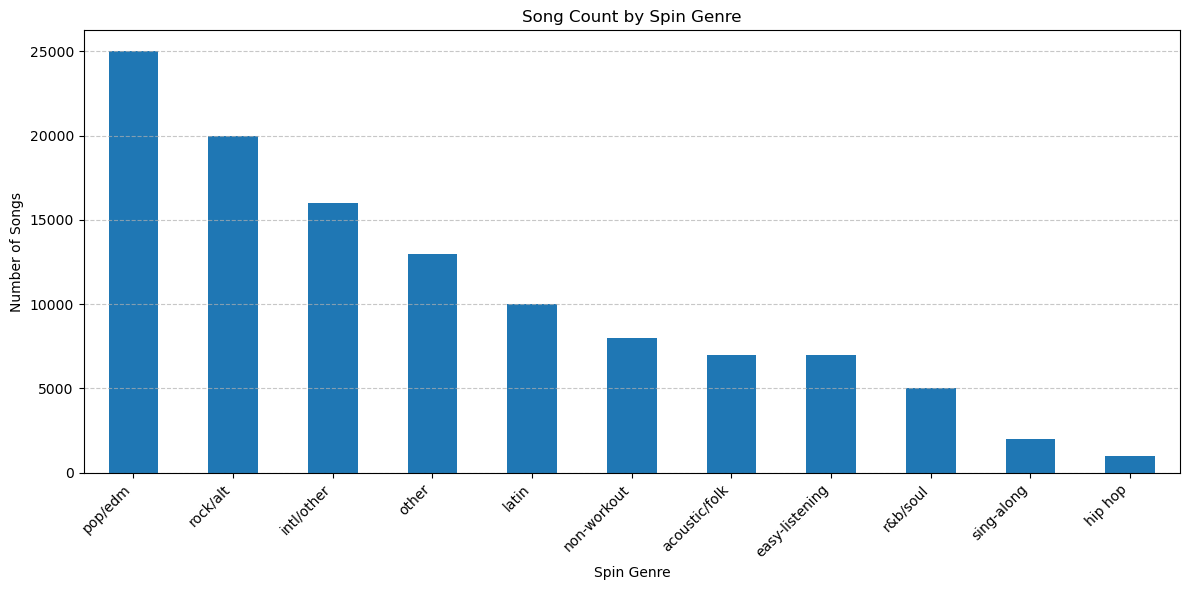

In [52]:
# Count number of songs per spin genre
genre_counts = df['spin_genre'].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title('Song Count by Spin Genre')
plt.xlabel('Spin Genre')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


These ratios are being created for the following reasons:
- Tempo:Energy | Adds nuance to how songs feel energetically across tempo bands and is especially useful in teasing apart interval, sprint, and warm up.
- Energy:Danceability | Captures how intensely energetic a track is relative to how rhythmically fluid or danceable it is.
- Energy:Loudness | Captures relative “punch” or intensity per decibel. Could help distinguish interval from sprint or climb.
- Valence: Danceability | Valence is more emotional; danceability is more rhythmic. A high ratio could flag “happy but undanceable” songs — useful for warm up or non-workout.
- Energy:Acousticness | Inversely correlated. A high value means highly energetic & non-acoustic (think club/dance), great for sprint detection.
- Loudness: Instrumentalness | High loudness but low instrumentalness could flag vocals-heavy intense songs — separating sprint or climb from ambient/cooldown tracks.

In [53]:
# Create tempo:energy ratio
df['tempo_energy_ratio'] = df['tempo'] / (df['energy'] + 1e-5)

# Create energy:danceability ratio
df['energy_danceability_ratio'] = df['energy'] / (df['danceability'] + 1e-5)

# Energy:loudness ratio
df['energy_loudness_ratio'] = df['energy'] / (df['loudness'] + 1e-5)

# Valence:danceability ratio
df['valence_danceability_ratio'] = df['valence'] / (df['danceability'] + 1e-5)

# Energy:acousticness ratio
df['energy_acousticness_ratio'] = df['energy'] / (df['acousticness'] + 1e-5)

# Loudness:instrumentalness ratio
df['loudness_instrumentalness_ratio'] = df['loudness'] / (df['instrumentalness'] + 1e-5)


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


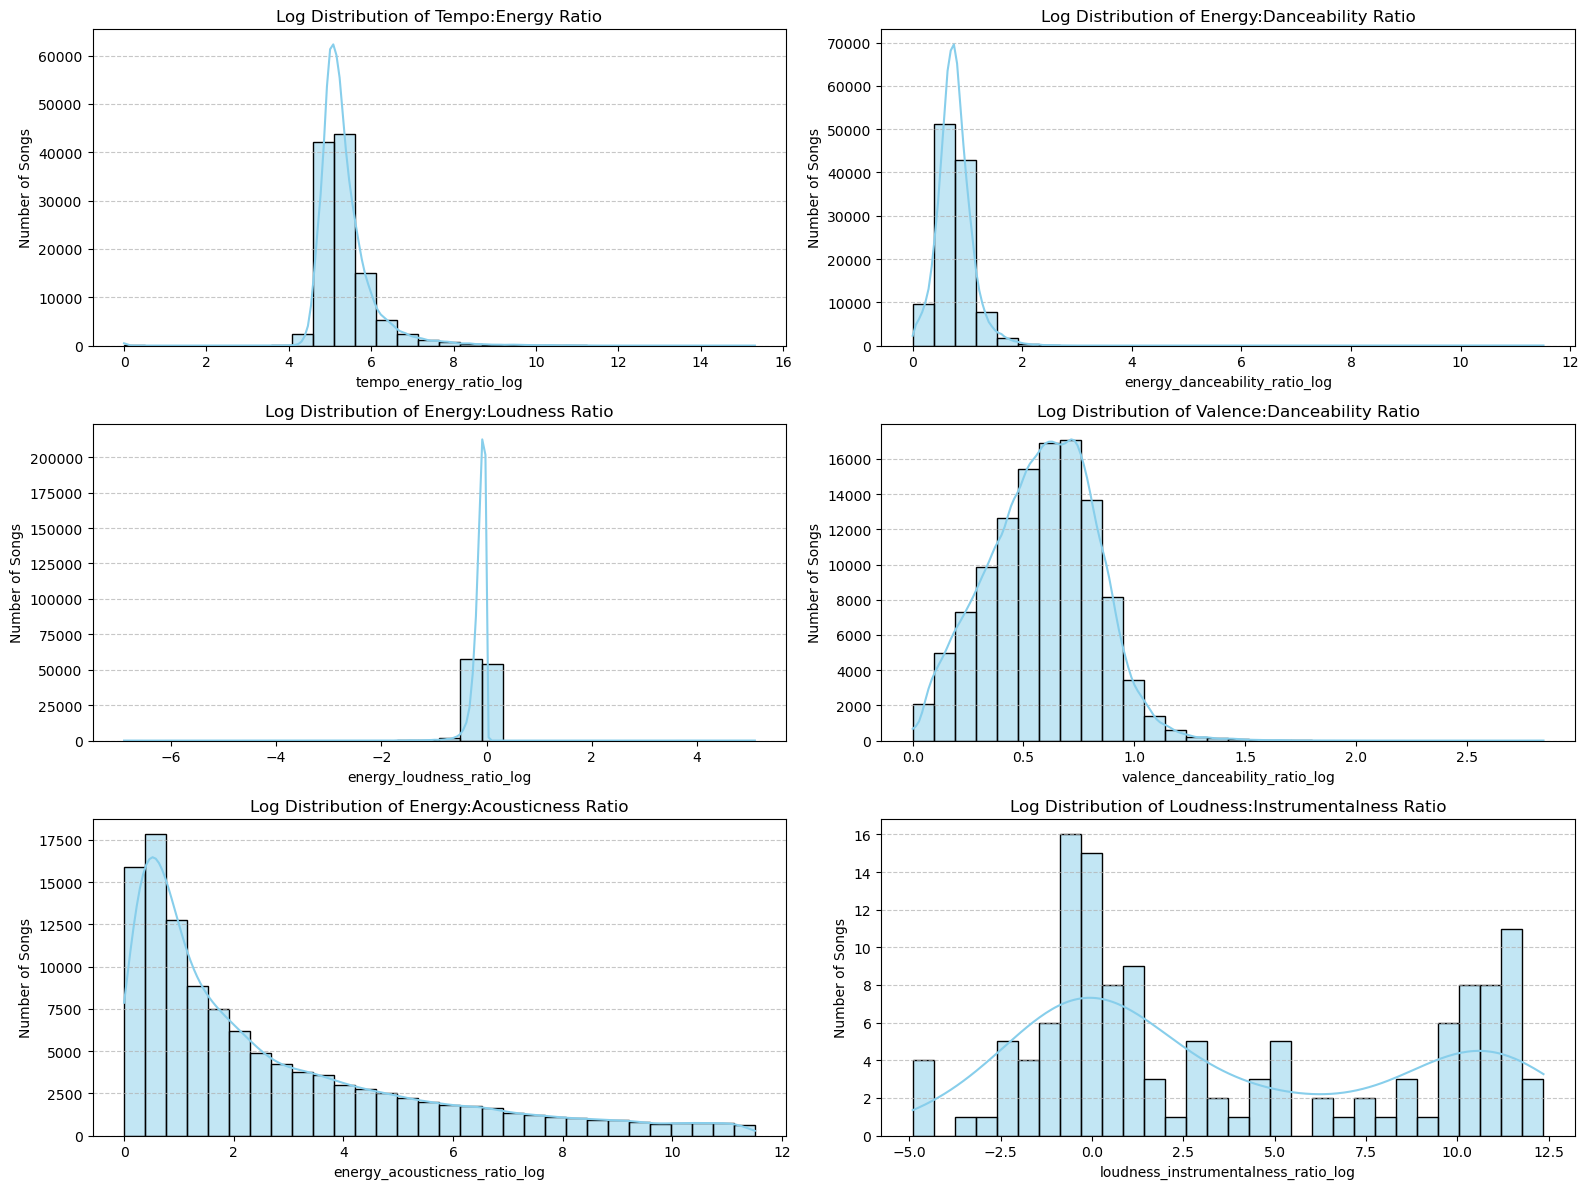

In [54]:
# Plot logged ratios
# Ratio creation function
def create_ratio_and_log(df, col1, col2, name):
    ratio_col = f'{name}_ratio'
    log_col = f'{name}_ratio_log'

    df[ratio_col] = df[col1] / (df[col2] + 1e-5)
    df[ratio_col] = df[ratio_col].replace([np.inf, -np.inf], np.nan)
    df[log_col] = np.log1p(df[ratio_col])
    df[log_col] = df[log_col].replace([np.inf, -np.inf], np.nan)
    
    return df

# Histogram plotting function that takes an Axes object
def plot_ratio_hist(ax, df, log_col, title=None, color='skyblue'):
    sns.histplot(df[log_col], bins=30, kde=True, color=color, ax=ax)
    ax.set_title(title or f'Distribution of {log_col}')
    ax.set_xlabel(log_col)
    ax.set_ylabel('Number of Songs')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Define all ratios
ratios_to_generate = [
    ('tempo', 'energy', 'tempo_energy'),
    ('energy', 'danceability', 'energy_danceability'),
    ('energy', 'loudness', 'energy_loudness'),
    ('valence', 'danceability', 'valence_danceability'),
    ('energy', 'acousticness', 'energy_acousticness'),
    ('loudness', 'instrumentalness', 'loudness_instrumentalness')
]

# Apply all ratios
for col1, col2, name in ratios_to_generate:
    df = create_ratio_and_log(df, col1, col2, name)

# Set up 3x2 subplot grid
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

# Plot each histogram
for ax, (_, _, name) in zip(axes, ratios_to_generate):
    log_col = f'{name}_ratio_log'
    title = f'Log Distribution of {name.replace("_", ":").title()} Ratio'
    plot_ratio_hist(ax, df, log_col, title)

plt.tight_layout()
plt.show()


In [55]:
# Create 'workout_type' (weighted scoring)
def assign_workout_type(row):
    # Non-workout conditions
    if (
        'white noise' in str(row['track_name']).lower()
        or 'nature sounds' in str(row['track_name']).lower()
        or row['speechiness'] > 0.66
        or row['duration_ms'] < 60 * 1000
        or row['duration_ms'] > 15 * 60 * 1000
        or row['acousticness'] > 0.9
    ):
        return 'non-workout'

    scores = {
        'sprint': 0,
        'interval': 0,
        'climb': 0,
        'warm up': 0,
        'cool down': 0
    }

    # Tempo
    if row['tempo'] > 140:
        scores['sprint'] += 2
    elif 125 < row['tempo'] <= 140:
        scores['interval'] += 2
    elif 110 < row['tempo'] <= 125:
        scores['climb'] += 2
    elif 85 <= row['tempo'] <= 110:
        scores['warm up'] += 2
    elif row['tempo'] < 85:
        scores['cool down'] += 2

    # Energy
    if row['energy'] > 0.9:
        scores['sprint'] += 2
    elif 0.8 < row['energy'] <= 0.9:
        scores['sprint'] += 1
        scores['interval'] += 2
    elif 0.55 < row['energy'] <= 0.8:
        scores['climb'] += 2
    elif row['energy'] < 0.5:
        scores['cool down'] += 3
        scores['warm up'] += 3

    # Valence
    if row['valence'] > 0.7:
        scores['sprint'] += 1
        scores['warm up'] += 1
    elif 0.5 <= row ['valence'] <= 0.7:
        scores['interval'] += 1
        scores['climb'] += 1
    elif row['valence'] < 0.5:
        scores['cool down'] += 3

    # Danceability
    if row['danceability'] > 0.65:
        scores['sprint'] += 1
        scores['interval'] += 1
        scores['climb'] += 1
    elif 0.4 <= row['danceability'] <= 0.65:
        scores['warm up'] += 1
    elif row['danceability'] < 0.4:
        scores['cool down'] += 1

    # Loudness
    if row['loudness'] > -5:
        scores['sprint'] += 1
    elif -10 <= row['loudness'] <= -5:
        scores['interval'] += 1
        scores['climb'] += 1
    elif row['loudness'] < -15:
        scores['cool down'] += 2

    # Instrumentalness
    if row['instrumentalness'] > 0.8:
        scores['cool down'] += 2
        scores['warm up'] += 1
    elif row['instrumentalness'] < 0.2:
        scores['sprint'] += 1
        scores['interval'] += 1

    # Speechiness (low values = music, high = spoken word)
    if 0.30 < row['speechiness'] <= 0.60:
        scores['cool down'] += 1
        scores['warm up'] += 1
    
    # Acousticness
    if 0.8 < row['acousticness'] >= 0.9:
        scores['cool down'] += 1


    return max(scores, key=scores.get) if max(scores.values()) > 0 else 'non-workout'


In [56]:
# # Creat 'workout_type' (simple)
# # Add column for workout type on subset
# def assign_workout_type(row):
#     tempo = row['tempo']
#     energy = row['energy']
#     valence = row['valence']
#     danceability = row['danceability']
    
#     if tempo > 130 and energy > 0.8 and valence > 0.3 and danceability > 0.55:
#         return 'sprint'
#     elif 120 <= tempo <= 130 and energy > 0.7:
#         return 'interval'
#     elif 110 <= tempo < 130 and 0.6 <= energy <= 0.8:
#         return 'climb'
#     elif 80 <= tempo < 110 and energy < 0.6 and valence > 0.3:
#         return 'warm up'
#     elif tempo < 100 and energy < 0.5 and valence > 0.4:
#         return 'cool down'
#     else:
#         return None  # leave ambiguous ones blank, this is where ML will come in

In [57]:
# Sample for heuristic labeling
sample_size = int(len(df) * 0.5) # taking 50% of the original dataset
sample_df = df.sample(sample_size, random_state=42).copy()

# Apply heuristic function from earlier
sample_df['workout_type'] = sample_df.apply(assign_workout_type, axis=1)

# Filter labeled rows only
training_data = sample_df.dropna(subset=['workout_type'])

print("Labeled rows:", len(training_data))
print(training_data['workout_type'].value_counts())

Labeled rows: 57000
workout_type
sprint         15947
cool down      12262
climb          10013
interval        9624
non-workout     5251
warm up         3903
Name: count, dtype: int64


In [58]:
# Inspect training data
# Filter to genre 
pop_training_data = training_data[training_data['track_genre'] == 'pop']

# Show 5 random pop songs per workout type
for workout in pop_training_data['workout_type'].unique():
    print(f"\n{workout.upper()} examples:")
    display(
        pop_training_data[
            pop_training_data['workout_type'] == workout
        ][['track_name', 'artists', 'tempo', 'energy', 'valence', 'danceability']].sample(3, random_state=42)
    )



SPRINT examples:


track_name                               artists    tempo  \
81707  Leave the Door Open  Bruno Mars;Anderson .Paak;Silk Sonic  148.088   
81553                Sorry                         Justin Bieber   99.945   
81242    Overpass Graffiti                            Ed Sheeran  175.908   

       energy  valence  danceability  
81707   0.616    0.719         0.586  
81553   0.760    0.410         0.654  
81242   0.849    0.774         0.520


CLIMB examples:


track_name  \
81660  Ilzaam (From the Album 'Industry')   
81632                              Ayyayo   
81581                      SI TÚ SUPIERAS   

                                                 artists    tempo  energy  \
81660                                 Arjun Kanungo;King   93.011   0.660   
81632  G. V. Prakash;S. P. Balasubrahmanyam;S.P. Char...   75.031   0.705   
81581                                               Feid  174.972   0.664   

       valence  danceability  
81660    0.301         0.697  
81632    0.733         0.608  
81581    0.586         0.673


INTERVAL examples:


track_name                    artists    tempo  energy  valence  \
81375             Ishqam  Mika Singh;Ali Quli Mirza  100.017   0.839    0.609   
81523  How You Like That                  BLACKPINK  130.018   0.787    0.326   
81312            Hold On              Justin Bieber  139.980   0.634    0.290   

       danceability  
81375         0.735  
81523         0.813  
81312         0.658


WARM UP examples:


track_name                       artists  \
81134  Stereo Hearts (feat. Adam Levine)  Gym Class Heroes;Adam Levine   
81316                     Teri Hogaiyaan                 Vishal Mishra   
81059       Dandelions - slowed + reverb                Ruth B.;slater   

         tempo  energy  valence  danceability  
81134   89.990   0.795    0.796         0.646  
81316  106.322   0.430    0.510         0.404  
81059  101.699   0.715    0.258         0.573


COOL DOWN examples:


track_name  \
81789  Jab Tak (From "M.S.Dhoni - The Untold Story")   
81549         Dangerous - David Guetta Banging Remix   
81389                           Ennodu Nee Irundhaal   

                                      artists    tempo  energy  valence  \
81789                            Armaan Malik  121.723   0.447   0.3210   
81549                 David Guetta;Sam Martin  128.004   0.931   0.0825   
81389  A.R. Rahman;Sid Sriram;Sunitha Sarathy  158.125   0.603   0.2070   

       danceability  
81789         0.299  
81549         0.698  
81389         0.261


NON-WORKOUT examples:


track_name    artists  tempo  energy  \
81830  Have Yourself A Merry Little Christmas  Sam Smith  75.25   0.178   
81843  Have Yourself A Merry Little Christmas  Sam Smith  75.25   0.178   
81888  Have Yourself A Merry Little Christmas  Sam Smith  75.25   0.178   

       valence  danceability  
81830    0.344         0.438  
81843    0.344         0.438  
81888    0.344         0.438

In [59]:
# # Manually adjust labels as necessary
# training_data.loc[:, 'manual_label'] = None

# # Add 'non-workout' classification for white noise and adjacent tracks
# training_data.loc[training_data['track_name'].str.contains("white noise|nature sounds", case=False, na=False), 'manual_label'] = 'non-workout'

# # Mark high-speechiness tracks as non-workout
# training_data.loc[training_data['speechiness'] > 0.66, 'manual_label'] = 'non-workout'

# # Mark tracks longer than 15 minutes or shorter than 60 seconds as non-workout
# training_data.loc[
#     (training_data['duration_ms'] > 15 * 60 * 1000) | (training_data['duration_ms'] < 60 * 1000),
#     'manual_label'
# ] = 'non-workout'

/var/folders/6j/5730h4y12159227rqs8wg2r80000gn/T/ipykernel_27516/692780682.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/var/folders/6j/5730h4y12159227rqs8wg2r80000gn/T/ipykernel_27516/692780682.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/var/folders/6j/5730h4y12159227rqs8wg2r80000gn/T/ipykernel_27516/692780682.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


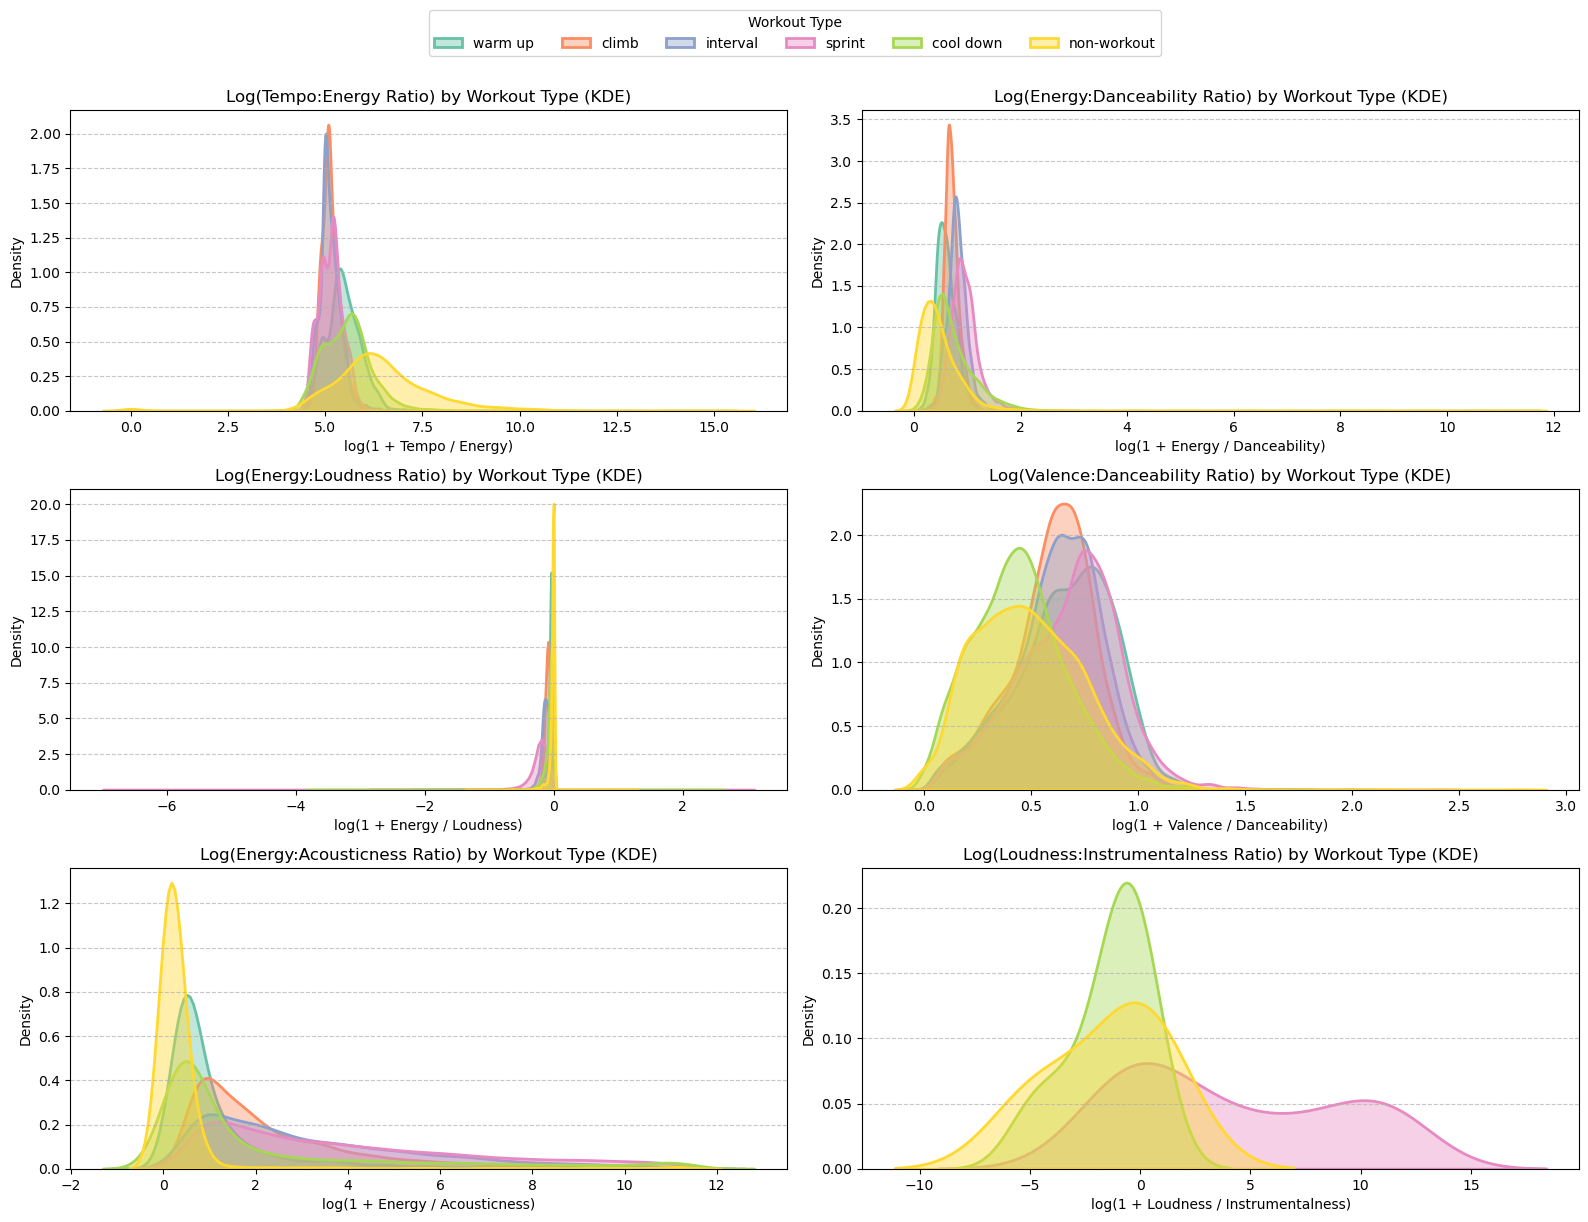

In [60]:
#Plot ratio features by workout type
def plot_kde_by_workout(ax, data, feature, title, xlabel, workouts=None, colors=None):
    if workouts is None:
        workouts = ['warm up', 'climb', 'interval', 'sprint', 'cool down', 'non-workout']
    
    if colors is None:
        colors = sns.color_palette('Set2', len(workouts))

    for workout, color in zip(workouts, colors):
        subset = data[data['workout_type'] == workout]
        sns.kdeplot(
            subset[feature],
            ax=ax,
            label=workout,
            fill=True,
            alpha=0.4,
            linewidth=2,
            color=color
        )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Density')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Features to plot
plot_features = [
    ('tempo_energy_ratio_log', 'Log(Tempo:Energy Ratio) by Workout Type (KDE)', 'log(1 + Tempo / Energy)'),
    ('energy_danceability_ratio_log', 'Log(Energy:Danceability Ratio) by Workout Type (KDE)', 'log(1 + Energy / Danceability)'),
    ('energy_loudness_ratio_log', 'Log(Energy:Loudness Ratio) by Workout Type (KDE)', 'log(1 + Energy / Loudness)'),
    ('valence_danceability_ratio_log', 'Log(Valence:Danceability Ratio) by Workout Type (KDE)', 'log(1 + Valence / Danceability)'),
    ('energy_acousticness_ratio_log', 'Log(Energy:Acousticness Ratio) by Workout Type (KDE)', 'log(1 + Energy / Acousticness)'),
    ('loudness_instrumentalness_ratio_log', 'Log(Loudness:Instrumentalness Ratio) by Workout Type (KDE)', 'log(1 + Loudness / Instrumentalness)')
]

# Create 3x2 subplot grid
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()  # Flatten to easily iterate

# Plot all features
for ax, (feature, title, xlabel) in zip(axes, plot_features):
    plot_kde_by_workout(ax, training_data, feature, title, xlabel)

# Final touches
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Workout Type", loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.02))
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for legend
plt.show()


- Tempo:Energy Ratio shows most workout types clustered between 5 and 6. Non-workout has a greater span. 
- Energy:Danceability Ratio again shows clustering of workout types. It may help separate higher intensity workouts (sprint & interval) from others. 
- Energy:Loudness Ratio shows all classes tightly clustered at 0. Minimal discriminatory weight, we'll drop this from the pipeline features.
- Valence:Danceability Ratio shows moderate overlap between all types. However, warm-up, cool-down, and non-workout seem slightly skewed left compared to more intense workouts (like sprint and interval). Valence (emotional positivity) may be lower relative to danceability in non-workout or cool-down music.
- Energy:Acousticness Ratio shows warm-up, cool down, and non-workout all skewed further left. Could be effective distinguishing low-energy, more acoustic tracks (used for cool down or non-workout) from high-energy, synthetic workout tracks. 
- Lots of missing values for Loudness:Instrumentalness which won't help separate workout classifications. 

## Pipeline Build + Model Deployment

In [61]:
# Split data
# # Using the manual label column as the primary then filling in with workout_type
# training_data.loc[:, 'label'] = training_data['manual_label'].fillna(training_data['workout_type'])

# Define features
numeric_features = [
    'tempo', 'energy', 'danceability', 'valence', 'loudness', 'acousticness', 
    'instrumentalness', 'speechiness', 'tempo_energy_ratio_log', 'energy_danceability_ratio_log',
    'valence_danceability_ratio_log', 'energy_acousticness_ratio_log']
categorical_features = ['track_genre']
features = numeric_features + categorical_features

X = training_data[features]
y = training_data['workout_type'] 

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data
X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.3, random_state=42)

In [62]:
from sklearn.utils.class_weight import compute_sample_weight

# Define preprocessor: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=-1),
    'SVM': SVC(probability=True, kernel='rbf', random_state=42)
}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', model)
    ])

    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_enc)

    # Fit the pipeline
    pipeline.fit(X_train, y_train_enc, clf__sample_weight=sample_weights)

    # Make predictions (this part was missing)
    y_pred_enc = pipeline.predict(X_test)
    y_pred = label_encoder.inverse_transform(y_pred_enc)
    y_test_decoded = label_encoder.inverse_transform(y_test_enc)

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test_decoded, y_pred))



Random Forest Classification Report:
              precision    recall  f1-score   support

       climb       0.95      0.96      0.96      3004
   cool down       0.94      0.97      0.95      3679
    interval       0.97      0.95      0.96      2887
 non-workout       1.00      0.94      0.97      1575
      sprint       0.97      0.98      0.97      4784
     warm up       0.93      0.89      0.91      1171

    accuracy                           0.96     17100
   macro avg       0.96      0.95      0.95     17100
weighted avg       0.96      0.96      0.96     17100


XGBoost Classification Report:
              precision    recall  f1-score   support

       climb       0.99      1.00      0.99      3004
   cool down       0.98      0.98      0.98      3679
    interval       0.99      0.99      0.99      2887
 non-workout       0.98      0.94      0.96      1575
      sprint       0.99      0.99      0.99      4784
     warm up       0.98      0.98      0.98      1171

    acc

In [63]:
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_sample_weight

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_idx, test_idx in cv.split(X, y_encoded):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y_encoded[train_idx], y_encoded[test_idx]

    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_cv)

    pipeline.fit(X_train_cv, y_train_cv, clf__sample_weight=sample_weights)
    y_pred_cv = pipeline.predict(X_test_cv)

    score = f1_score(y_test_cv, y_pred_cv, average='macro')
    scores.append(score)

print("Stratified K-Fold F1 Macro Scores:", scores)
print("Average F1 Macro Score:", np.mean(scores))


Stratified K-Fold F1 Macro Scores: [0.9785500633474286, 0.9838140114393572, 0.9812969766801404, 0.977601454381729, 0.9785951866745007]
Average F1 Macro Score: 0.9799715385046313


In [104]:
# RandomizedSearchCV
# ColumnTransformer setup
numeric_features = [
    'tempo', 'energy', 'danceability', 'valence', 'loudness', 'acousticness', 
    'instrumentalness', 'speechiness', 'tempo_energy_ratio_log', 'energy_danceability_ratio_log',
    'valence_danceability_ratio_log', 'energy_acousticness_ratio_log']
categorical_features = ['track_genre']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

# Parameter space
param_dist = {
    'clf__n_estimators': [100, 200, 250, 300],
    'clf__max_depth': [3, 5, 7, 9, 10],
    'clf__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2, 0.3],
    'clf__subsample': [0.5, 0.6, 0.7, 0.8, 1.0],
    'clf__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 1.0],
    # extra additions to improve CV
    'clf__gamma': [0, 0.1, 0.3, 0.5],
    'clf__min_child_weight': [1, 3, 5]
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run randomized search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=cv,
    scoring='f1_macro',
    verbose=0,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train_enc)

# Best model
print("Best params:", random_search.best_params_)
print("Best F1 Macro Score:", random_search.best_score_)


Best params: {'clf__subsample': 0.8, 'clf__n_estimators': 250, 'clf__min_child_weight': 1, 'clf__max_depth': 5, 'clf__learning_rate': 0.3, 'clf__gamma': 0.5, 'clf__colsample_bytree': 1.0}
Best F1 Macro Score: 0.9784388067008851


Interesting that this is sliiiiiightly lower than the XGBoost CV score. I fear we've reached a performance ceiling. Thankfully they're both hovering around .98, which is an excellent result either way. 

In [105]:
# Save model
import joblib
joblib.dump(random_search.best_estimator_, 'workout_classifier.pkl')

['workout_classifier.pkl']

<Figure size 1000x800 with 0 Axes>

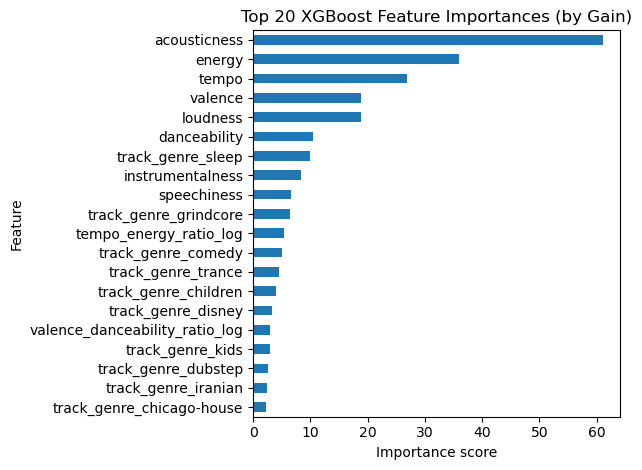

In [106]:
# Visualize feature importance

# Load trained pipeline and extract steps
pipeline = joblib.load('workout_classifier.pkl')
model = pipeline.named_steps['clf']
preprocessor = pipeline.named_steps['preprocessor']

# Get feature names
num_feats = numeric_features
cat_feats = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([num_feats, cat_feats])

# Map feature importances
booster = model.get_booster()
importance = booster.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': [feature_names[int(f[1:])] for f in importance],
    'Gain': list(importance.values())
}).sort_values(by='Gain', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
importance_df.head(20).plot(kind='barh', x='Feature', y='Gain', legend=False)
plt.title("Top 20 XGBoost Feature Importances (by Gain)")
plt.xlabel("Importance score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

 98%|===================| 1172/1200 [00:16<00:00]        

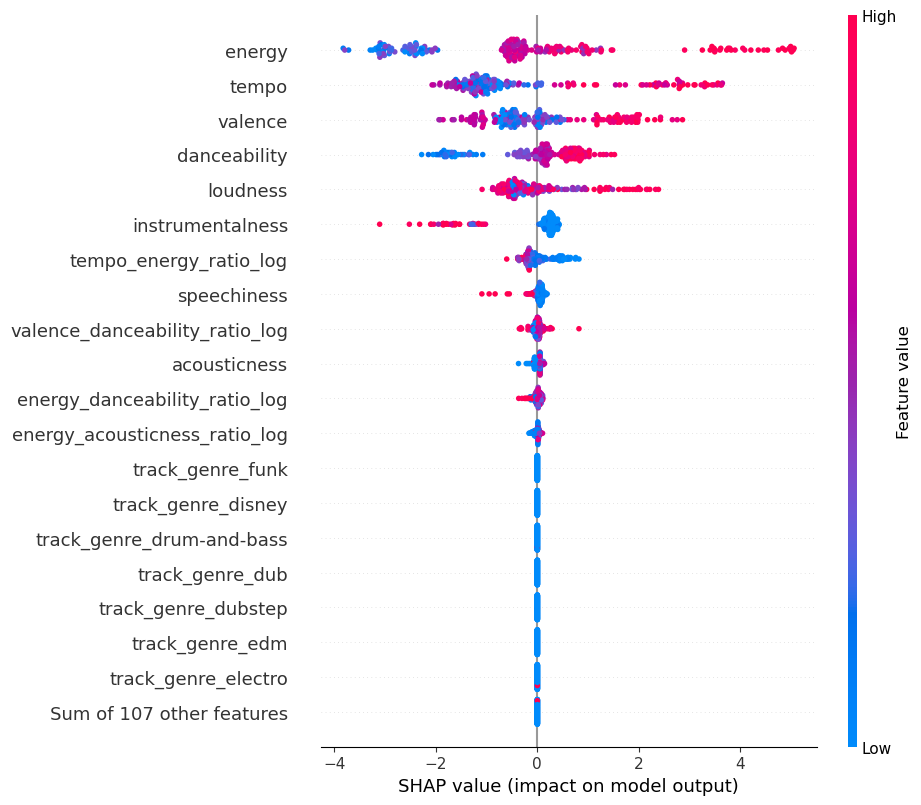

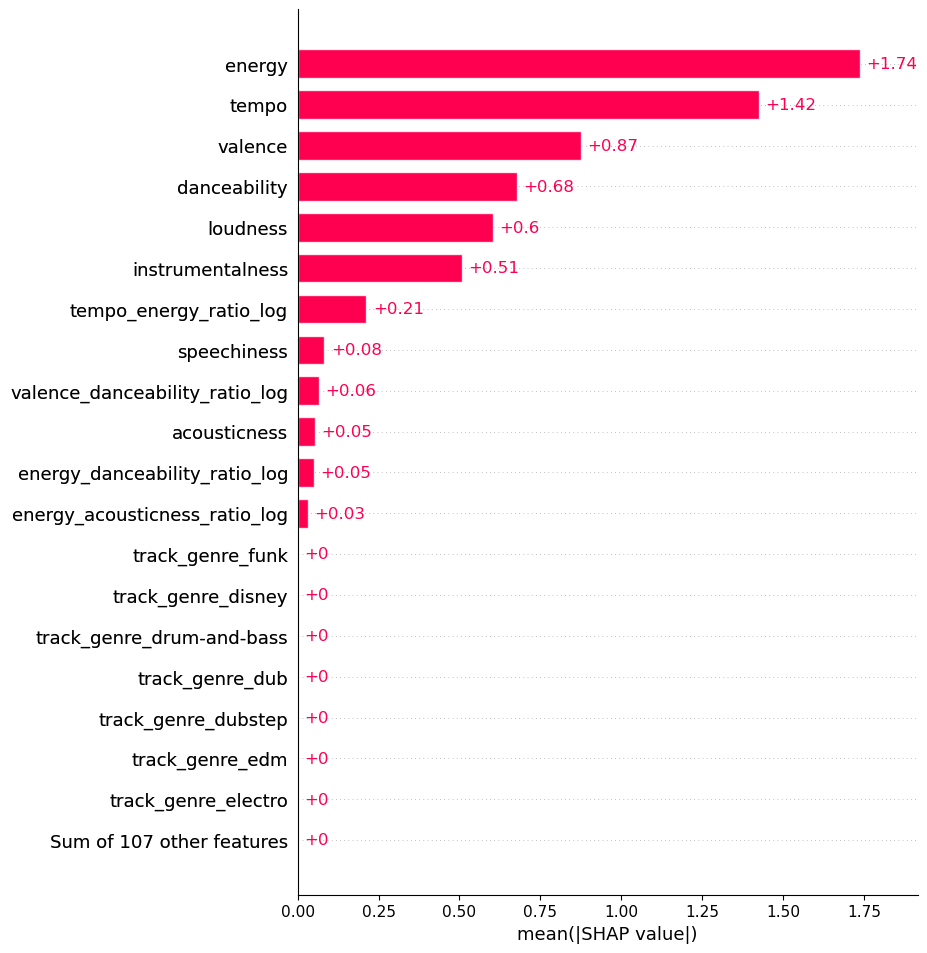

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the pipeline again
pipeline = joblib.load('workout_classifier.pkl')
model = pipeline.named_steps['clf']
preprocessor = pipeline.named_steps['preprocessor']

# Prepare transformed training data
X_train_transformed = preprocessor.transform(X_train).toarray()

# Get feature names after transformation
num_feats = numeric_features
cat_feats = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([num_feats, cat_feats])

# SHAP Explainer for XGBoost
explainer = shap.Explainer(model, X_train_transformed, feature_names=feature_names)

# Compute SHAP values for a sample
shap_values = explainer(X_train_transformed[:200])

# Plot chart
class_name = 'sprint'  # Change this to another workout type as needed!
class_index = list(label_encoder.classes_).index(class_name)

# Extract SHAP values for this class
shap_values_class = shap_values[..., class_index]

# Beeswarm plot (local interpretability)
shap.plots.beeswarm(shap_values_class, max_display=20)

# Bar plot (global importance)
shap.plots.bar(shap_values_class, max_display=20)

<Figure size 1000x700 with 0 Axes>

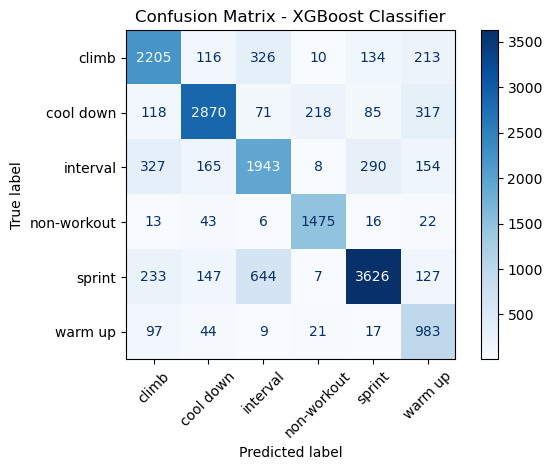

In [133]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred, labels=label_encoder.classes_)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Plot it
plt.figure(figsize=(10, 7))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - XGBoost Classifier")
plt.grid(False)
plt.tight_layout()
plt.show()


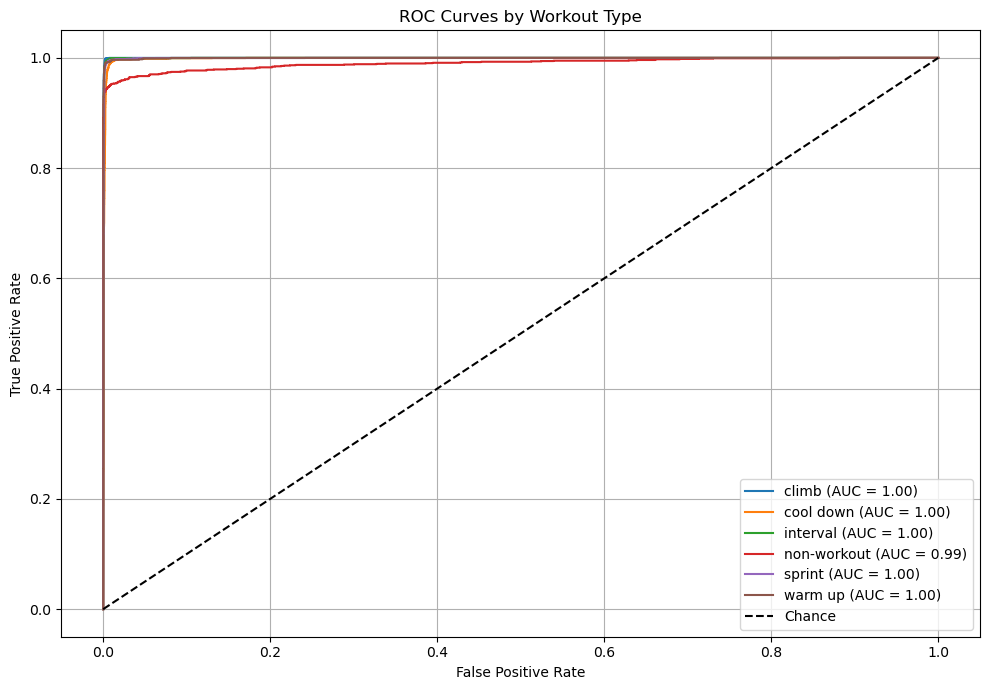

In [134]:
# ROC-AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

# Use the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Binarize the labels for multi-class ROC
y_test_binarized = label_binarize(y_test_enc, classes=np.arange(len(label_encoder.classes_)))
y_score = best_model.predict_proba(X_test)

# Create ROC curve for each class
n_classes = y_test_binarized.shape[1]
plt.figure(figsize=(10, 7))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title("ROC Curves by Workout Type")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Results show clear separation between classes; the model is highly confident at distinguishing workout types. Non-workout AUC is slightly lower, but expected due to the nature of this class. 

In [109]:
# Use the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Apply model to unlabeled songs
unlabeled_songs = df[~df['track_id'].isin(training_data['track_id'])].copy()

# Predict labels using the best model
X_unlabeled = unlabeled_songs[X_train.columns]
unlabeled_songs['workout_type'] = best_model.predict(X_unlabeled)
unlabeled_songs['workout_type'] = label_encoder.inverse_transform(unlabeled_songs['workout_type'])

# Filter out non-workout tracks
usable_songs = unlabeled_songs[unlabeled_songs['workout_type'] != 'non-workout']


In [110]:
# Sample predictions
usable_songs[['track_name', 'artists', 'track_genre', 'spin_genre', 'workout_type', 'tempo', 'energy', 'danceability', 'valence', 'loudness', 'acousticness', 'instrumentalness', 'speechiness']].sample(5)


track_name  \
1617                                        Allema Timba   
77759        Ser Feliz De Novo - Live From Brazil / 2001   
97033  Meu Anjo / Esqueça Que Eu Te Amo / É Amor Dema...   
84727                                        Sana Değmez   
87742                                            Família   

                              artists track_genre spin_genre workout_type  \
1617   Alogte Oho & His Sounds of Joy    afrobeat      other      warm up   
77759                            Belo      pagode      latin     interval   
97033                     Murilo Huff   sertanejo      other    cool down   
84727                         3 Hürel  psych-rock   rock/alt    cool down   
87742                           Titãs       r-n-b   r&b/soul       sprint   

         tempo  energy  danceability  valence  loudness  acousticness  \
1617   141.120   0.458         0.631    0.945    -8.889        0.3840   
77759  112.336   0.878         0.584    0.842    -9.177        0.4460   
97033  141.643   0.542         0.362    0.298    -6.311        0.5320   
84727  160.043   0.364         0.511    0.543   -16.941        0.0782   
87742   94.963   0.651         0.798    0.964   -11.015        0.0531   

       instrumentalness  speechiness  
1617            0.03160       0.0327  
77759           0.00000       0.0981  
97033           0.00000       0.0514  
84727           0.43500       0.0444  
87742           0.00159       0.0772

## Workout Type Feature Distribution

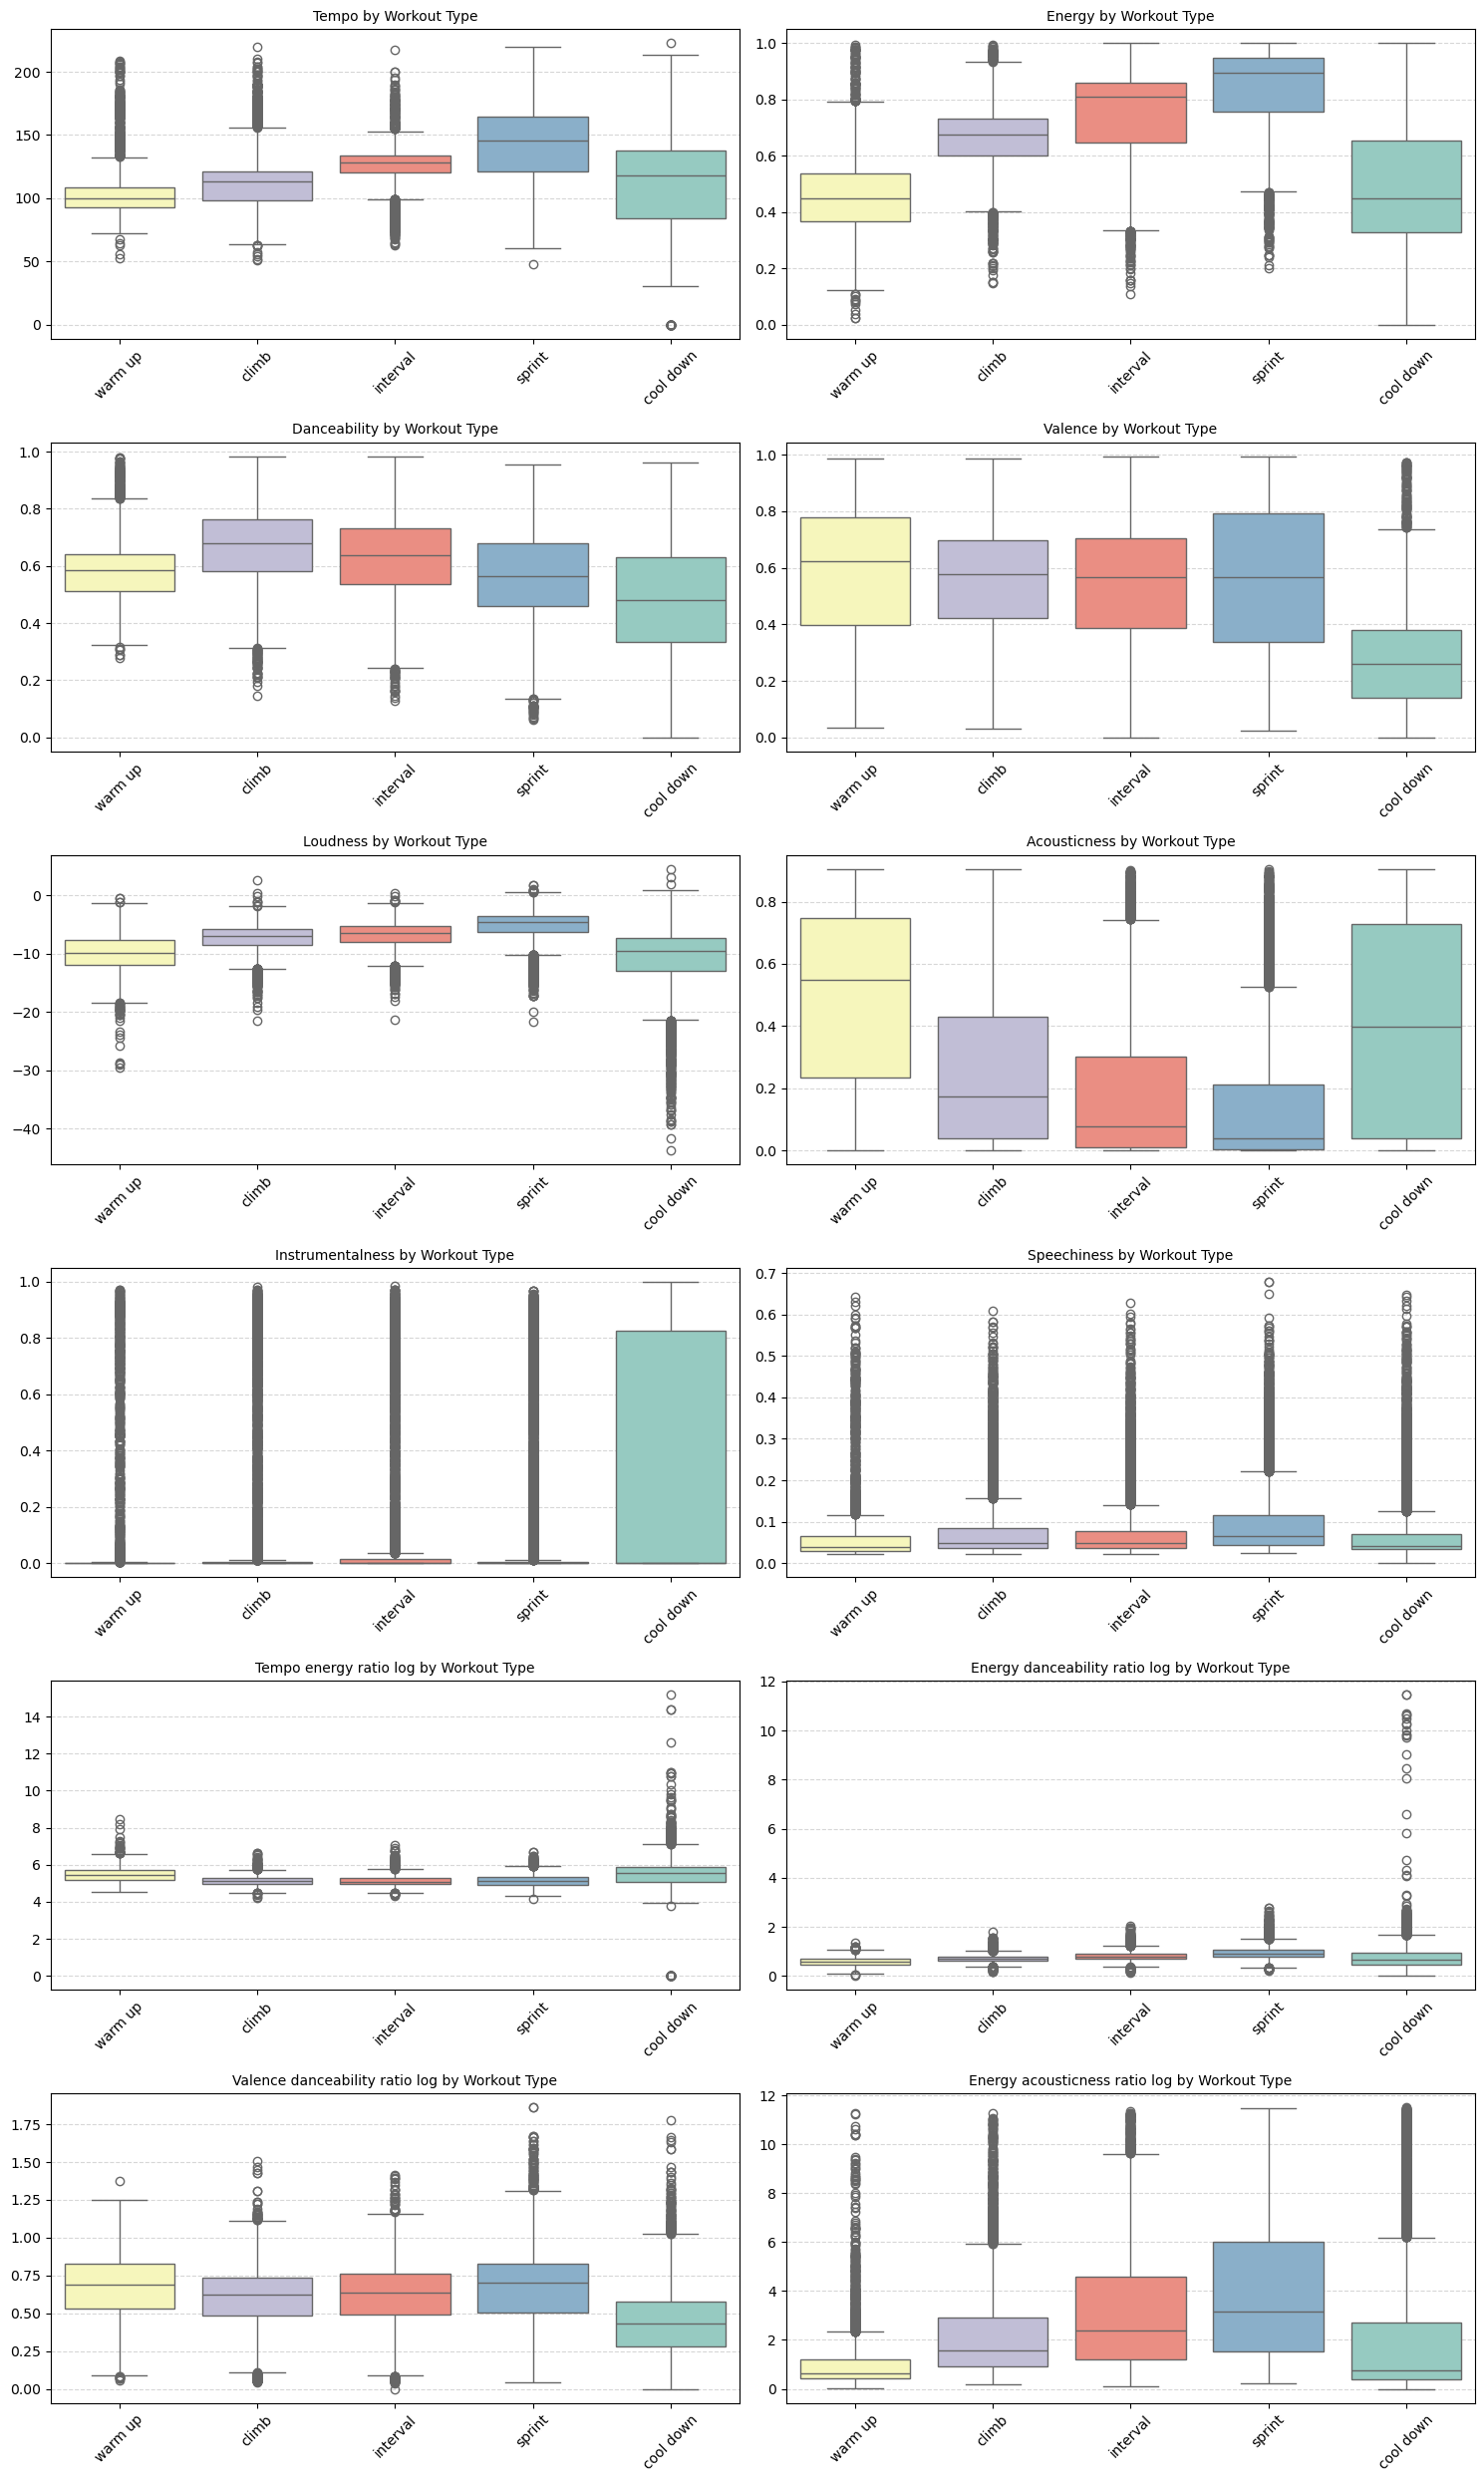

In [111]:
# Features to visualize + order
features = [
    'tempo', 'energy', 'danceability', 'valence', 'loudness', 'acousticness', 
    'instrumentalness', 'speechiness', 'tempo_energy_ratio_log', 'energy_danceability_ratio_log',
    'valence_danceability_ratio_log', 'energy_acousticness_ratio_log']
workout_order = ['warm up', 'climb', 'interval', 'sprint', 'cool down']

# Set up the subplot grid
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 25))
axes = axes.flatten()  # flatten to easily iterate

# Loop through each feature and create a boxplot grouped by predicted workout type
for idx, feature in enumerate(features):
    ax = axes[idx]
    sns.boxplot(
        data=usable_songs,
        x='workout_type',
        y=feature,
        hue='workout_type',
        palette='Set3',
        order=workout_order,
        ax=ax,
        legend=False
    )
    ax.set_title(f'{feature.replace("_", " ").capitalize()} by Workout Type', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Hide any empty subplots if features < total grid size
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

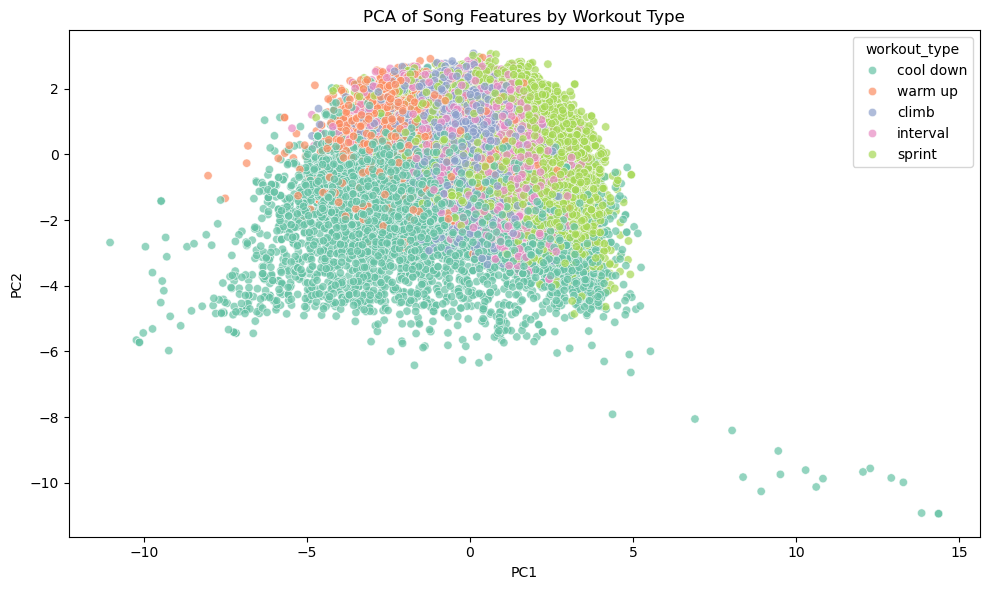

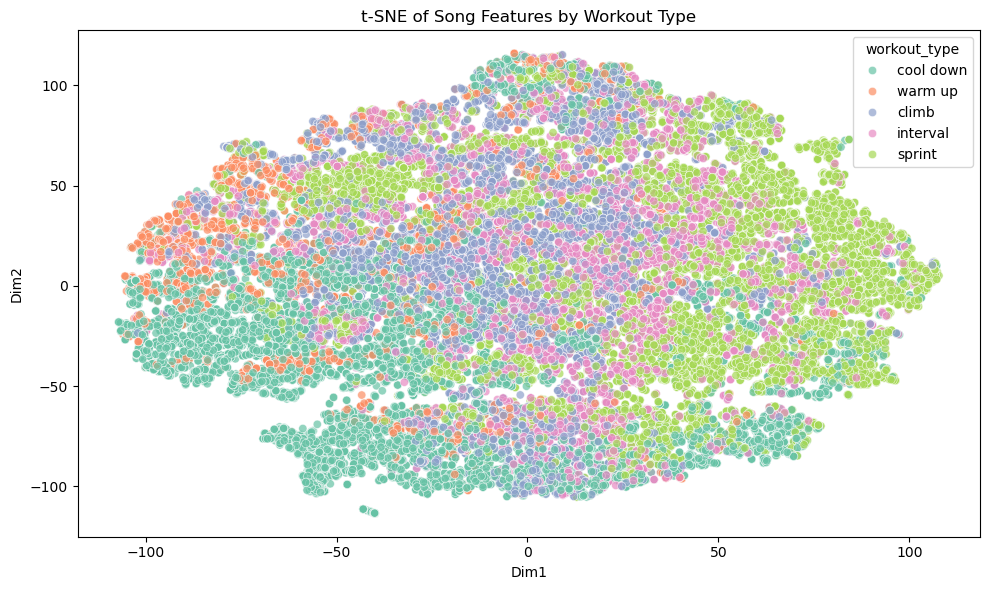

In [112]:
# PCA and t-SNE test
# Select features to embed
features = [
    'tempo', 'energy', 'danceability', 'valence', 'loudness', 'acousticness', 
    'instrumentalness', 'speechiness', 'tempo_energy_ratio_log', 'energy_danceability_ratio_log',
    'valence_danceability_ratio_log', 'energy_acousticness_ratio_log']
X = usable_songs[features].dropna()
y = usable_songs.loc[X.index, 'workout_type']

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA (2D)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['workout_type'] = y.values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='workout_type', palette='Set2', alpha=0.7)
plt.title("PCA of Song Features by Workout Type")
plt.tight_layout()
plt.show()

# t-SNE (2D)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
tsne_result = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(tsne_result, columns=['Dim1', 'Dim2'])
tsne_df['workout_type'] = y.values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='workout_type', palette='Set2', alpha=0.7)
plt.title("t-SNE of Song Features by Workout Type")
plt.tight_layout()
plt.show()


PCA
- Sprint and Interval are clustered more tightly and to the far right of PC1, indicating they have distinct, high-energy profiles.
- Warm-up, climb, and cool down show heavier overlap in the left and central parts of the plot.

t-SNE
- Model has learned distinct zones for fast-paced workouts (interval, sprint).
- It handles fuzzier transitions between warm up, climb, and cool down, which makes sense musically and physically.
- t-SNE shows nonlinear clustering that PCA can't, validating label choices and feature set.

In [113]:
# See how much each original feature contributes to PC1 and PC2
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
print(loadings)


                                     PC1       PC2
tempo                           0.086041  0.004166
energy                          0.478503  0.080570
danceability                   -0.082529  0.370672
valence                         0.040535  0.594268
loudness                        0.371139  0.209778
acousticness                   -0.398293  0.077444
instrumentalness                0.003330 -0.366021
speechiness                     0.073020  0.080329
tempo_energy_ratio_log         -0.388420 -0.080663
energy_danceability_ratio_log   0.372828 -0.216727
valence_danceability_ratio_log  0.102115  0.463864
energy_acousticness_ratio_log   0.391351 -0.209438


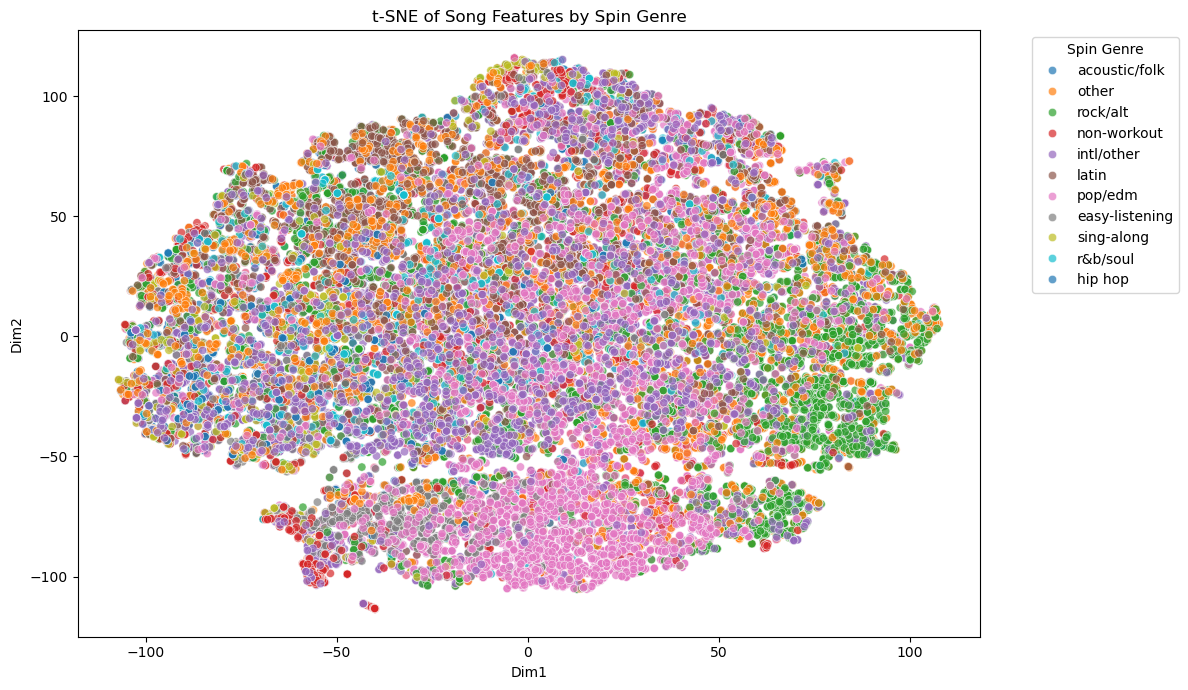

In [114]:
# t-SNE with spin_genre instead of label
# Ensure spin_genre aligns with the t-SNE inputs
tsne_df['spin_genre'] = usable_songs.loc[X.index, 'spin_genre'].values

# Plot t-SNE by spin genre
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=tsne_df,
    x='Dim1',
    y='Dim2',
    hue='spin_genre',
    palette='tab10',
    alpha=0.7
)
plt.title("t-SNE of Song Features by Spin Genre")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Spin Genre')
plt.tight_layout()
plt.show()


- Pop/EDM, Rock/Alt, Hip Hop, and Acoustic/Folk show clear gravitational pull in different zones.
- These genres tend to have tight production profiles, which tempo, energy, and valence reflect well.
- Latin and Intl/Other aren't sonically homogeneous—they include ballads, reggaeton, pop crossover, etc.
- This spread suggests that language and cultural flavor are not always captured in low-level audio features

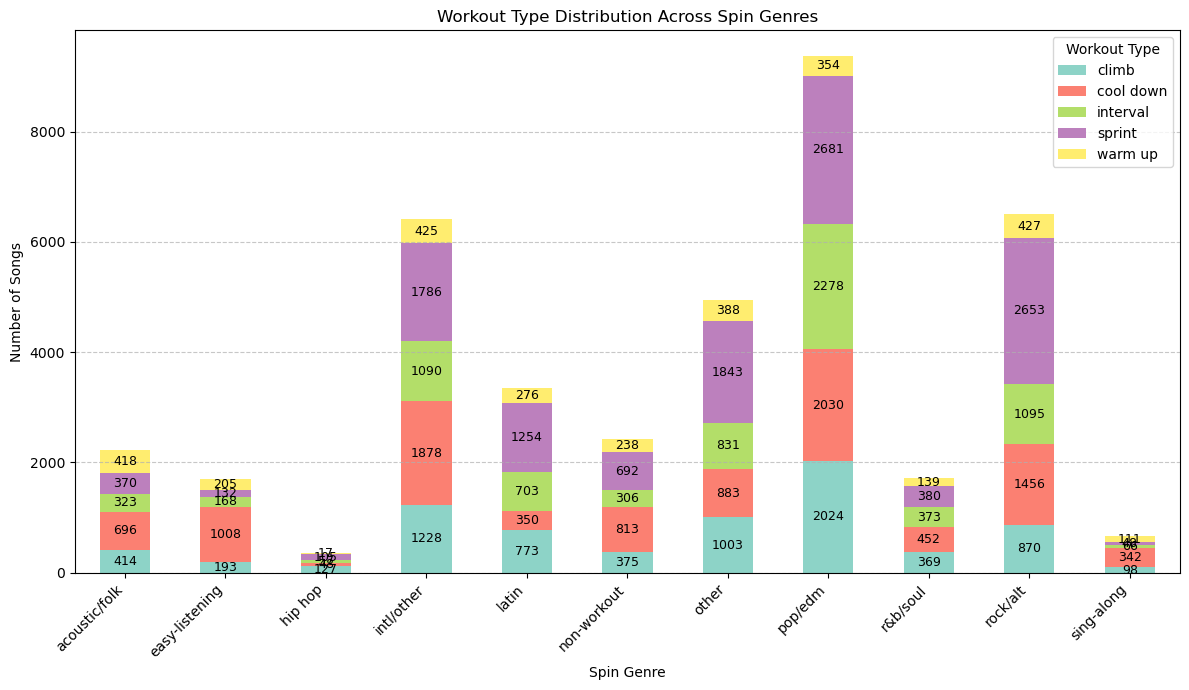

In [115]:
# Plot workout type by genre
# Create pivot table
genre_label_counts = usable_songs.pivot_table(
    index='spin_genre',
    columns='workout_type',
    aggfunc='size',
    fill_value=0
)

# Plot stacked bar chart
ax = genre_label_counts.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='Set3')

# Add value labels
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.annotate(
                f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                ha='center',
                va='center',
                fontsize=9,
                color='black'
            )

# Format chart
plt.title("Workout Type Distribution Across Spin Genres")
plt.xlabel("Spin Genre")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Workout Type')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

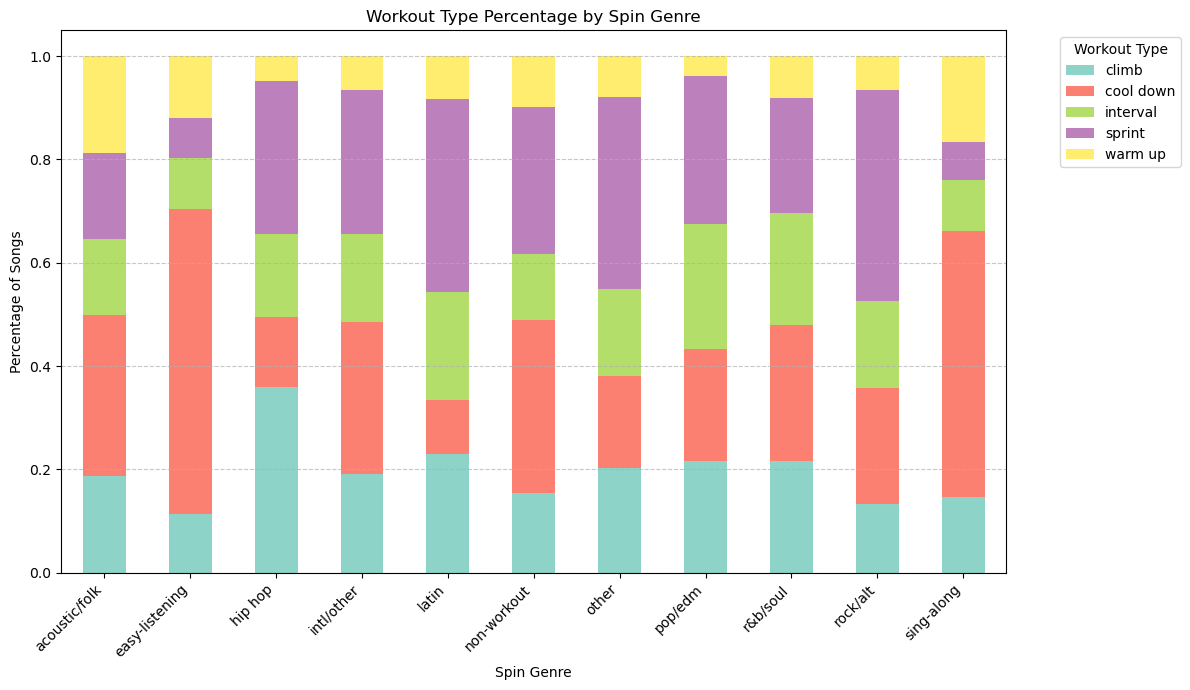

In [116]:
# Workout Type Percentage by Spin Genre
# Create pivot table of counts
genre_label_counts = usable_songs.pivot_table(
    index='spin_genre',
    columns='workout_type',
    aggfunc='size',
    fill_value=0
)

# Normalize each row to get percentages
genre_label_percent = genre_label_counts.div(genre_label_counts.sum(axis=1), axis=0)

# Plot
genre_label_percent.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='Set3')

plt.title("Workout Type Percentage by Spin Genre")
plt.xlabel("Spin Genre")
plt.ylabel("Percentage of Songs")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Workout Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Playlist building

In [139]:
# Constant Variables
# Shared constants
playlist_structures = {
    'balanced': ['warm up', 'interval', 'sprint', 'interval', 'climb',
                 'interval', 'sprint', 'interval', 'climb', 'cool down'],
    'speed': ['warm up', 'interval', 'sprint', 'interval', 'warm up',
              'interval', 'sprint', 'interval', 'sprint', 'cool down'],
    'climb': ['warm up', 'interval', 'climb', 'interval', 'climb',
              'warm up', 'climb', 'interval', 'climb', 'cool down'],
    'recovery': ['warm up', 'interval', 'interval', 'cool down', 'interval',
                 'interval', 'cool down', 'interval', 'cool down', 'cool down']
}

spin_genres = [
    'pop/edm', 'rock/alt', 'hip hop', 'r&b/soul', 'acoustic/folk', 
    'latin', 'easy-listening', 'intl/other', 'sing-along'
]

# Shuffle songs once and reuse
usable_songs_shuffled = usable_songs.sample(frac=1, random_state=42).copy()

# Utility: Song finder
def find_song(df, workout_type, used_tracks, popularity_thresholds=[75, 55, 30, 10]):
    for threshold in popularity_thresholds:
        match = df[
            (df['workout_type'] == workout_type) &
            (df['popularity'] >= threshold) &
            (~df['track_name'].isin(used_tracks))
        ]
        if not match.empty:
            return match.sample(1).copy()
    return pd.DataFrame()

# Utility: Playlist display
def display_playlist(playlist, title=None):
    if title:
        print(f"\n{title}\n{'=' * len(title)}")
    display_df = playlist[['workout_type', 'track_name', 'artists', 'track_genre', 'tempo', 'energy', 
                           'danceability', 'valence', 'loudness', 'acousticness', 'instrumentalness', 'speechiness',]].copy()
    display_df['spotify_url'] = "https://open.spotify.com/track/" + playlist['track_id']
    display(display_df)
    total_ms = playlist['duration_ms'].sum()
    total_min, total_sec = divmod(int(total_ms / 1000), 60)
    print(f"Total duration: {total_min} min {total_sec} sec")


### Single Playlist Generator

In [140]:
# Settings
structure_key = 'balanced'
selected_genre = 'pop/edm'

# Filter songs for the genre
genre_songs = usable_songs_shuffled[usable_songs_shuffled['spin_genre'] == selected_genre]
used_tracks = set()
playlist = pd.DataFrame()

# Generate playlist
for stage in playlist_structures[structure_key]:
    song = find_song(genre_songs, stage, used_tracks)
    if not song.empty:
        used_tracks.add(song.iloc[0]['track_name'])
        playlist = pd.concat([playlist, song], ignore_index=True)

# Display
display_playlist(playlist, title=f"Single Playlist | Genre: {selected_genre} | Structure: {structure_key}")



Single Playlist | Genre: pop/edm | Structure: balanced


workout_type                                         track_name  \
0      warm up                     For My Hand (feat. Ed Sheeran)   
1     interval                                 Return of the Mack   
2       sprint                                           Reptilia   
3     interval                                            Run BTS   
4        climb                                             Levels   
5     interval                                              IDGAF   
6       sprint  Vegas (From the Original Motion Picture Soundt...   
7     interval                                    Runaway (U & I)   
8        climb         We Don't Talk Anymore (feat. Selena Gomez)   
9    cool down                                            7 rings   

                                  artists track_genre    tempo  energy  \
0                    Burna Boy;Ed Sheeran       dance  104.059   0.479   
1                           Mark Morrison     british   95.487   0.833   
2                             The Strokes      garage  158.009   0.649   
3                                     BTS         pop   77.004   0.818   
4  Sidhu Moose Wala;Sunny Malton;The Kidd         pop  113.170   0.728   
5                                Dua Lipa       dance   97.028   0.544   
6                                Doja Cat       dance  159.969   0.601   
7                                Galantis       house  126.008   0.805   
8               Charlie Puth;Selena Gomez         pop  100.017   0.563   
9                           Ariana Grande       dance  140.048   0.317   

   danceability  valence  loudness  acousticness  instrumentalness  \
0         0.870    0.717    -7.779      0.161000          0.000157   
1         0.715    0.612    -5.379      0.006310          0.000000   
2         0.489    0.770    -5.110      0.000603          0.713000   
3         0.724    0.696    -3.747      0.020100          0.000000   
4         0.592    0.577    -6.098      0.001480          0.000000   
5         0.836    0.510    -5.975      0.040300          0.000000   
6         0.801    0.740    -7.574      0.077700          0.000032   
7         0.506    0.383    -4.119      0.007110          0.001930   
8         0.728    0.352    -8.053      0.621000          0.000000   
9         0.778    0.327   -10.732      0.592000          0.000000   

   speechiness                                        spotify_url  
0       0.1650  https://open.spotify.com/track/0HaRLPnr887lcQM...  
1       0.1080  https://open.spotify.com/track/3jDdpx9PMlfMBS5...  
2       0.0336  https://open.spotify.com/track/57Xjny5yNzAcsxn...  
3       0.1680  https://open.spotify.com/track/69xohKu8C1fsflY...  
4       0.3110  https://open.spotify.com/track/60YICjIPdL7LDBc...  
5       0.0943  https://open.spotify.com/track/76cy1WJvNGJTj78...  
6       0.2550  https://open.spotify.com/track/0hquQWY3xvYqN4q...  
7       0.0469  https://open.spotify.com/track/46lFttIf5hnUZMG...  
8       0.1340  https://open.spotify.com/track/06KyNuuMOX1ROXR...  
9       0.3340  https://open.spotify.com/track/6ocbgoVGwYJhOv1...

Total duration: 34 min 9 sec


### Multiple Playlists by Genre

In [143]:
# Settings
selected_genre = 'pop/edm'
genre_songs = usable_songs_shuffled[usable_songs_shuffled['spin_genre'] == selected_genre]

# Loop through each structure type
for structure_key, structure in playlist_structures.items():
    used_tracks = set()
    playlist = pd.DataFrame()

    for stage in structure:
        song = find_song(genre_songs, stage, used_tracks)
        if not song.empty:
            used_tracks.add(song.iloc[0]['track_name'])
            playlist = pd.concat([playlist, song], ignore_index=True)

    display_playlist(playlist, title=f"{structure_key.upper()} Ride | Genre: {selected_genre}")



BALANCED Ride | Genre: pop/edm


workout_type                                  track_name  \
0      warm up                                    Memories   
1     interval                             Runaway (U & I)   
2       sprint                                  STARGAZING   
3     interval                                  Bad Habits   
4        climb                  (I Just) Died In Your Arms   
5     interval                                    YOSEMITE   
6       sprint                       The One That Got Away   
7     interval                                      Summer   
8        climb  We Don't Talk Anymore (feat. Selena Gomez)   
9    cool down     Dusk Till Dawn (feat. Sia) - Radio Edit   

                     artists track_genre    tempo  energy  danceability  \
0                   Maroon 5         pop   91.050   0.327         0.775   
1                   Galantis         edm  126.008   0.805         0.506   
2               Travis Scott       house  150.007   0.789         0.487   
3                 Ed Sheeran         pop  126.011   0.893         0.807   
4               Cutting Crew   synth-pop  124.945   0.726         0.625   
5               Travis Scott       house  128.047   0.554         0.785   
6                 Katy Perry       dance  133.971   0.795         0.691   
7              Calvin Harris     electro  127.949   0.856         0.596   
8  Charlie Puth;Selena Gomez       dance  100.017   0.563         0.728   
9                   ZAYN;Sia         pop  180.042   0.437         0.259   

   valence  loudness  acousticness  instrumentalness  speechiness  \
0   0.5950    -7.241      0.841000          0.000000       0.0557   
1   0.3830    -4.119      0.007110          0.001930       0.0469   
2   0.0564    -3.690      0.009470          0.000004       0.0440   
3   0.5370    -3.745      0.045100          0.000028       0.0347   
4   0.5070   -11.402      0.015800          0.000169       0.0444   
5   0.1440    -6.571      0.283000          0.000003       0.0409   
6   0.8760    -4.021      0.000812          0.000001       0.0355   
7   0.7430    -3.556      0.021100          0.017800       0.0346   
8   0.3520    -8.053      0.621000          0.000000       0.1340   
9   0.0951    -6.589      0.102000          0.000001       0.0386   

                                         spotify_url  
0  https://open.spotify.com/track/4cktbXiXOapiLBM...  
1  https://open.spotify.com/track/46lFttIf5hnUZMG...  
2  https://open.spotify.com/track/7wBJfHzpfI3032C...  
3  https://open.spotify.com/track/3rmo8F54jFF8OgY...  
4  https://open.spotify.com/track/4ByEFOBuLXpCqvO...  
5  https://open.spotify.com/track/7lAK3oHbfEnvUQW...  
6  https://open.spotify.com/track/4uQY80TKE1u4ZQZ...  
7  https://open.spotify.com/track/6YUTL4dYpB9xZO5...  
8  https://open.spotify.com/track/06KyNuuMOX1ROXR...  
9  https://open.spotify.com/track/3e7sxremeOE3wTy...

Total duration: 37 min 35 sec

SPEED Ride | Genre: pop/edm


workout_type                 track_name                     artists  \
0      warm up                Imagination                Shawn Mendes   
1     interval          Super Freaky Girl                 Nicki Minaj   
2       sprint      If We Have Each Other               Alec Benjamin   
3     interval                 Knee Socks              Arctic Monkeys   
4      warm up                    Shallow    Lady Gaga;Bradley Cooper   
5     interval                    Run BTS                         BTS   
6       sprint  Head & Heart (feat. MNEK)             Joel Corry;MNEK   
7     interval    Sexy Bitch (feat. Akon)           David Guetta;Akon   
8       sprint              All By Myself  Alok;Sigala;Ellie Goulding   
9    cool down                 ocean eyes               Billie Eilish   

  track_genre    tempo  energy  danceability  valence  loudness  acousticness  \
0       dance   89.948   0.455         0.640    0.333    -5.942        0.0743   
1       dance  133.010   0.891         0.950    0.912    -2.653        0.0645   
2     electro  173.094   0.577         0.656    0.861    -5.566        0.6980   
3      garage   97.975   0.542         0.665    0.587    -8.323        0.1230   
4       dance   95.799   0.385         0.572    0.323    -6.362        0.3710   
5         pop   77.004   0.818         0.724    0.696    -3.747        0.0201   
6         edm  122.953   0.874         0.734    0.905    -3.158        0.1680   
7         edm  130.011   0.627         0.813    0.801    -5.018        0.0771   
8       house  123.041   0.848         0.662    0.773    -4.338        0.0932   
9     electro  144.892   0.363         0.511    0.169    -7.650        0.8160   

   instrumentalness  speechiness  \
0          0.000000       0.0247   
1          0.000018       0.2410   
2          0.000000       0.0802   
3          0.002910       0.0330   
4          0.000000       0.0308   
5          0.000000       0.1680   
6          0.000011       0.0662   
7          0.000616       0.0486   
8          0.000008       0.0346   
9          0.031700       0.0410   

                                         spotify_url  
0  https://open.spotify.com/track/21TcDbGosp7w9Yh...  
1  https://open.spotify.com/track/4C6Uex2ILwJi9sZ...  
2  https://open.spotify.com/track/7pT6WSg4PCt4mr5...  
3  https://open.spotify.com/track/2LGdO5MtFdyphi2...  
4  https://open.spotify.com/track/2VxeLyX666F8uXC...  
5  https://open.spotify.com/track/69xohKu8C1fsflY...  
6  https://open.spotify.com/track/6cx06DFPPHchuUA...  
7  https://open.spotify.com/track/127uq83uGFapbdd...  
8  https://open.spotify.com/track/5Hp4xFihdOE2dmD...  
9  https://open.spotify.com/track/7hDVYcQq6MxkdJG...

Total duration: 33 min 2 sec

CLIMB Ride | Genre: pop/edm


workout_type                       track_name  \
0      warm up  Eastside (with Halsey & Khalid)   
1     interval                             Baby   
2        climb                           Levels   
3     interval                           Summer   
4        climb                           Insane   
5      warm up                   Therefore I Am   
6        climb       (I Just) Died In Your Arms   
7     interval                        Typa Girl   
8        climb                 Story of My Life   
9    cool down                           Homage   

                                         artists track_genre    tempo  energy  \
0                     benny blanco;Halsey;Khalid     electro   89.391   0.680   
1                         Justin Bieber;Ludacris         pop   65.043   0.859   
2         Sidhu Moose Wala;Sunny Malton;The Kidd         pop  113.170   0.728   
3                                  Calvin Harris       house  127.949   0.856   
4  AP Dhillon;Shinda Kahlon;Gurinder Gill;Gminxr         pop   98.967   0.572   
5                                  Billie Eilish     electro   94.009   0.340   
6                                   Cutting Crew   synth-pop  124.945   0.726   
7                                      BLACKPINK         pop  131.966   0.585   
8                                  One Direction         pop  121.070   0.663   
9                                 Mild High Club      garage   73.369   0.465   

   danceability  valence  loudness  acousticness  instrumentalness  \
0         0.560    0.319    -7.648       0.55500          0.000000   
1         0.728    0.535    -5.237       0.04010          0.000000   
2         0.592    0.577    -6.098       0.00148          0.000000   
3         0.596    0.743    -3.556       0.02110          0.017800   
4         0.796    0.304    -7.030       0.41600          0.000025   
5         0.889    0.716    -7.773       0.21800          0.130000   
6         0.625    0.507   -11.402       0.01580          0.000169   
7         0.918    0.519    -7.781       0.06270          0.000000   
8         0.600    0.286    -5.802       0.22500          0.000000   
9         0.546    0.415    -8.167       0.15300          0.002590   

   speechiness                                        spotify_url  
0       0.3210  https://open.spotify.com/track/0d2iYfpKoM0QCKv...  
1       0.1370  https://open.spotify.com/track/6epn3r7S14KUqlR...  
2       0.3110  https://open.spotify.com/track/60YICjIPdL7LDBc...  
3       0.0346  https://open.spotify.com/track/6YUTL4dYpB9xZO5...  
4       0.0545  https://open.spotify.com/track/3UhmuWcFaLS3AO3...  
5       0.0697  https://open.spotify.com/track/54bFM56PmE4YLRn...  
6       0.0444  https://open.spotify.com/track/4ByEFOBuLXpCqvO...  
7       0.0889  https://open.spotify.com/track/3BHR1mJOqn2UZyq...  
8       0.0477  https://open.spotify.com/track/4nVBt6MZDDP6tRV...  
9       0.0287  https://open.spotify.com/track/7DcJ6fEBb7BaKuY...

Total duration: 35 min 2 sec

RECOVERY Ride | Genre: pop/edm


workout_type                       track_name               artists  \
0      warm up   For My Hand (feat. Ed Sheeran)  Burna Boy;Ed Sheeran   
1     interval                 Call Out My Name            The Weeknd   
2     interval               Return of the Mack         Mark Morrison   
3    cool down               Moral of the Story                  Ashe   
4     interval                   Don’t Blame Me          Taylor Swift   
5     interval                       Knee Socks        Arctic Monkeys   
6    cool down                          7 rings         Ariana Grande   
7     interval                        Typa Girl             BLACKPINK   
8    cool down               Little Do You Know         Alex & Sierra   
9    cool down  Come Together - Remastered 2009           The Beatles   

  track_genre    tempo  energy  danceability  valence  loudness  acousticness  \
0       dance  104.059   0.479         0.870    0.717    -7.779       0.16100   
1         pop  134.170   0.593         0.461    0.175    -4.954       0.17000   
2     british   95.487   0.833         0.715    0.612    -5.379       0.00631   
3     electro  119.812   0.406         0.572    0.265    -8.624       0.58700   
4         pop  135.917   0.534         0.615    0.193    -6.719       0.10600   
5      garage   97.975   0.542         0.665    0.587    -8.323       0.12300   
6       dance  140.048   0.317         0.778    0.327   -10.732       0.59200   
7         pop  131.966   0.585         0.918    0.519    -7.781       0.06270   
8         pop  145.879   0.292         0.500    0.370    -8.554       0.74600   
9     british  165.007   0.376         0.533    0.187   -11.913       0.03020   

   instrumentalness  speechiness  \
0          0.000157       0.1650   
1          0.000000       0.0356   
2          0.000000       0.1080   
3          0.000004       0.0427   
4          0.000018       0.0386   
5          0.002910       0.0330   
6          0.000000       0.3340   
7          0.000000       0.0889   
8          0.000000       0.0323   
9          0.248000       0.0393   

                                         spotify_url  
0  https://open.spotify.com/track/0HaRLPnr887lcQM...  
1  https://open.spotify.com/track/09mEdoA6zrmBPgT...  
2  https://open.spotify.com/track/3jDdpx9PMlfMBS5...  
3  https://open.spotify.com/track/2nC3QhMI9reBIOW...  
4  https://open.spotify.com/track/1R0a2iXumgCiFb7...  
5  https://open.spotify.com/track/2LGdO5MtFdyphi2...  
6  https://open.spotify.com/track/6ocbgoVGwYJhOv1...  
7  https://open.spotify.com/track/3BHR1mJOqn2UZyq...  
8  https://open.spotify.com/track/1almCHdsfikRPfV...  
9  https://open.spotify.com/track/2EqlS6tkEnglzr7...

Total duration: 34 min 58 sec


### Multiple Genres by Playlist Structure

In [142]:
# Settings
structure_key = 'speed'
structure = playlist_structures[structure_key]

# Loop through each genre
for genre in spin_genres:
    genre_songs = usable_songs_shuffled[usable_songs_shuffled['spin_genre'] == genre]
    used_tracks = set()
    playlist = pd.DataFrame()

    for stage in structure:
        song = find_song(genre_songs, stage, used_tracks)
        if not song.empty:
            used_tracks.add(song.iloc[0]['track_name'])
            playlist = pd.concat([playlist, song], ignore_index=True)

    display_playlist(playlist, title=f"{genre.upper()} | Structure: {structure_key}")



POP/EDM | Structure: speed


workout_type                                         track_name  \
0      warm up  Valerie - Live At BBC Radio 1 Live Lounge, Lon...   
1     interval                                               Baby   
2       sprint                                       Heart Attack   
3     interval                                            Snowman   
4      warm up                       Maiyya Mainu (From "Jersey")   
5     interval                                    Runaway (U & I)   
6       sprint                                             Melody   
7     interval                                 Return of the Mack   
8       sprint                                          CAN'T SAY   
9    cool down                                            Heather   

                          artists track_genre    tempo  energy  danceability  \
0                   Amy Winehouse     british   96.574   0.371         0.772   
1          Justin Bieber;Ludacris         pop   65.043   0.859         0.728   
2                     Demi Lovato       dance  173.968   0.785         0.504   
3                             Sia       dance  104.957   0.512         0.716   
4  Sachet-Parampara;Sachet Tandon         pop  109.985   0.739         0.630   
5                        Galantis       house  126.008   0.805         0.506   
6                          Sigala         edm  123.017   0.910         0.630   
7                   Mark Morrison     british   95.487   0.833         0.715   
8                    Travis Scott       house  147.980   0.708         0.702   
9                      Conan Gray         pop  102.078   0.425         0.357   

   valence  loudness  acousticness  instrumentalness  speechiness  \
0    0.684    -5.743       0.74400          0.000000       0.0348   
1    0.535    -5.237       0.04010          0.000000       0.1370   
2    0.502    -4.802       0.07380          0.000000       0.1040   
3    0.326    -6.257       0.48300          0.000000       0.0331   
4    0.224    -3.942       0.19400          0.000000       0.0248   
5    0.383    -4.119       0.00711          0.001930       0.0469   
6    0.525    -2.681       0.02310          0.000002       0.0580   
7    0.612    -5.379       0.00631          0.000000       0.1080   
8    0.713    -5.366       0.20100          0.000000       0.0547   
9    0.270    -7.301       0.58400          0.000000       0.0333   

                                         spotify_url  
0  https://open.spotify.com/track/6nLvaCZFR1wEzW3...  
1  https://open.spotify.com/track/6epn3r7S14KUqlR...  
2  https://open.spotify.com/track/1V6gIisPpYqgFeW...  
3  https://open.spotify.com/track/7uoFMmxln0GPXQ0...  
4  https://open.spotify.com/track/4PwTeFfKqmR3XIe...  
5  https://open.spotify.com/track/46lFttIf5hnUZMG...  
6  https://open.spotify.com/track/6Owc2SuzwO3LW1S...  
7  https://open.spotify.com/track/3jDdpx9PMlfMBS5...  
8  https://open.spotify.com/track/27a1mYSG5tYg7dm...  
9  https://open.spotify.com/track/4xqrdfXkTW4T0Ra...

Total duration: 34 min 20 sec

ROCK/ALT | Structure: speed


workout_type                                         track_name  \
0      warm up                                   Suspicious Minds   
1     interval                                            Dragula   
2       sprint                                        Not Allowed   
3     interval                                         In the End   
4      warm up                                      Mount Everest   
5     interval   Danger Zone - From "Top Gun" Original Soundtrack   
6       sprint  C.R.E.A.M. (Cash Rules Everything Around Me) (...   
7     interval                     Fuck Love (feat. Trippie Redd)   
8       sprint                                        Basket Case   
9    cool down                                         All I Want   

                                             artists  track_genre    tempo  \
0                                      Elvis Presley   rockabilly  116.557   
1                                         Rob Zombie        metal  125.030   
2                                            TV Girl    indie-pop  104.965   
3                                        Linkin Park  alternative  105.143   
4                                           Labrinth    indie-pop   87.724   
5                                      Kenny Loggins         rock  157.170   
6  Wu-Tang Clan;Method Man;Raekwon;Inspectah Deck...     hardcore  180.985   
7                          XXXTENTACION;Trippie Redd          emo  131.036   
8                                          Green Day         punk   85.064   
9                                           Kodaline         rock  187.376   

   energy  danceability  valence  loudness  acousticness  instrumentalness  \
0   0.382         0.487    0.714   -10.889      0.042200          0.000005   
1   0.963         0.591    0.609    -6.489      0.000087          0.000107   
2   0.905         0.670    0.563    -6.855      0.669000          0.000227   
3   0.864         0.556    0.400    -5.870      0.009580          0.000000   
4   0.428         0.494    0.440    -7.239      0.236000          0.069800   
5   0.897         0.544    0.647    -6.056      0.241000          0.000000   
6   0.549         0.479    0.576   -10.551      0.570000          0.023500   
7   0.533         0.797    0.329    -9.740      0.017200          0.000152   
8   0.943         0.442    0.781    -3.205      0.002930          0.000009   
9   0.411         0.188    0.159    -9.733      0.174000          0.153000   

   speechiness                                        spotify_url  
0       0.0309  https://open.spotify.com/track/1H5IfYyIIAlgDX8...  
1       0.0531  https://open.spotify.com/track/6Nm8h73ycDG2saC...  
2       0.1290  https://open.spotify.com/track/3IznIgmXtrUaoPW...  
3       0.0584  https://open.spotify.com/track/60a0Rd6pjrkxjPb...  
4       0.2050  https://open.spotify.com/track/1ZdhOMWyFR8Iv9e...  
5       0.0471  https://open.spotify.com/track/34x6hEJgGAOQvml...  
6       0.3730  https://open.spotify.com/track/119c93MHjrDLJTA...  
7       0.0412  https://open.spotify.com/track/7AQim7LbvFVZJE3...  
8       0.0602  https://open.spotify.com/track/6L89mwZXSOwYl76...  
9       0.0484  https://open.spotify.com/track/0NlGoUyOJSuSHmn...

Total duration: 35 min 27 sec

HIP HOP | Structure: speed


workout_type                             track_name  \
0      warm up          Kannazhaga - The Kiss of Love   
1     interval                               Superman   
2       sprint      INDUSTRY BABY (feat. Jack Harlow)   
3     interval  Quevedo: Bzrp Music Sessions, Vol. 52   
4      warm up            Sajna, Say Yes To The Dress   
5     interval                          Old Town Road   
6       sprint                 Astronaut In The Ocean   
7     interval                            Look At Me!   
8       sprint                                HUMBLE.   
9    cool down                         Thousand Miles   

                                     artists track_genre    tempo  energy  \
0  Anirudh Ravichander;Dhanush;Shruti Haasan     hip-hop  109.935   0.496   
1                            Eminem;Dina Rae     hip-hop  130.027   0.755   
2                      Lil Nas X;Jack Harlow     hip-hop  150.087   0.691   
3                           Bizarrap;Quevedo     hip-hop  128.033   0.782   
4                          Badshah;Payal Dev     hip-hop  107.636   0.776   
5                                  Lil Nas X     hip-hop  135.998   0.530   
6                                Masked Wolf     hip-hop  149.996   0.695   
7                               XXXTENTACION     hip-hop  139.059   0.726   
8                             Kendrick Lamar     hip-hop  150.011   0.621   
9                              The Kid LAROI     hip-hop   80.565   0.657   

   danceability  valence  loudness  acousticness  instrumentalness  \
0         0.574    0.610    -7.153      0.431000          0.000000   
1         0.802    0.580    -3.138      0.021500          0.000000   
2         0.741    0.892    -7.395      0.022100          0.000000   
3         0.621    0.550    -5.548      0.012500          0.033000   
4         0.633    0.889    -3.839      0.296000          0.000000   
5         0.907    0.507    -6.112      0.057800          0.000002   
6         0.778    0.472    -6.865      0.175000          0.000000   
7         0.763    0.349    -6.405      0.259000          0.000000   
8         0.908    0.421    -6.638      0.000282          0.000054   
9         0.376    0.203    -4.658      0.085800          0.000000   

   speechiness                                        spotify_url  
0       0.0277  https://open.spotify.com/track/2MwCoo4GeXpi8so...  
1       0.0564  https://open.spotify.com/track/4woTEX1wYOTGDqN...  
2       0.0672  https://open.spotify.com/track/5Z9KJZvQzH6PFmb...  
3       0.0440  https://open.spotify.com/track/2tTmW7RDtMQtBk7...  
4       0.1730  https://open.spotify.com/track/3YV4Go0hpYXjGTG...  
5       0.1270  https://open.spotify.com/track/0F7FA14euOIX8Kc...  
6       0.0913  https://open.spotify.com/track/3Ofmpyhv5UAQ70m...  
7       0.2820  https://open.spotify.com/track/7floNISpH8VF4z4...  
8       0.1020  https://open.spotify.com/track/7KXjTSCq5nL1LoY...  
9       0.0768  https://open.spotify.com/track/1r8ZCjfrQxoy2wV...

Total duration: 30 min 39 sec

R&B/SOUL | Structure: speed


workout_type                                         track_name  \
0      warm up                                             No One   
1     interval                              Ele Te Bota Soca Soca   
2       sprint                     Rock with You - Single Version   
3     interval                                   Forgot About Dre   
4      warm up  Valerie - Live At BBC Radio 1 Live Lounge, Lon...   
5     interval                                          September   
6       sprint                                   The Next Episode   
7     interval                                 Return of the Mack   
8       sprint                                         In My Head   
9    cool down                                                Ivy   

                                artists track_genre    tempo  energy  \
0                           Alicia Keys        soul   90.040   0.549   
1  MC Mazzie;Mc Rd;DJ NpcSize;DJ Wizard        funk  130.138   0.746   
2                       Michael Jackson        soul  114.031   0.535   
3                        Dr. Dre;Eminem        funk  133.974   0.740   
4                         Amy Winehouse        soul   96.574   0.371   
5                    Earth, Wind & Fire        funk  125.926   0.832   
6                    Dr. Dre;Snoop Dogg        funk   95.295   0.909   
7                         Mark Morrison        soul   95.487   0.833   
8                              Lil Tjay       r-n-b  143.049   0.545   
9                           Frank Ocean        soul  116.408   0.386   

   danceability  valence  loudness  acousticness  instrumentalness  \
0         0.644    0.167    -5.415       0.02090          0.000009   
1         0.896    0.752    -5.174       0.10800          0.000001   
2         0.808    0.848   -12.521       0.17900          0.000099   
3         0.924    0.621    -1.299       0.08270          0.000000   
4         0.772    0.684    -5.743       0.74400          0.000000   
5         0.697    0.979    -7.264       0.16800          0.001310   
6         0.922    0.309    -2.429       0.02810          0.000000   
7         0.715    0.612    -5.379       0.00631          0.000000   
8         0.684    0.407    -6.885       0.15900          0.000000   
9         0.575    0.466    -9.584       0.78500          0.000289   

   speechiness                                        spotify_url  
0       0.0285  https://open.spotify.com/track/6IwKcFdiRQZOWeY...  
1       0.0720  https://open.spotify.com/track/30096a5EMOSaF9c...  
2       0.0353  https://open.spotify.com/track/7oOOI85fVQvVnK5...  
3       0.0774  https://open.spotify.com/track/7iXF2W9vKmDoGAh...  
4       0.0348  https://open.spotify.com/track/6nLvaCZFR1wEzW3...  
5       0.0298  https://open.spotify.com/track/2grjqo0Frpf2okI...  
6       0.2700  https://open.spotify.com/track/4LwU4Vp6od3Sb08...  
7       0.1080  https://open.spotify.com/track/3jDdpx9PMlfMBS5...  
8       0.1210  https://open.spotify.com/track/1HvTxgCj0mTzQlE...  
9       0.0370  https://open.spotify.com/track/2ZWlPOoWh0626oT...

Total duration: 34 min 45 sec

ACOUSTIC/FOLK | Structure: speed


workout_type                                         track_name  \
0      warm up                                    Beautiful Crazy   
1     interval                                      Fortunate Son   
2       sprint                            In Case You Didn't Know   
3     interval                                          Free Bird   
4      warm up  Until I Found You (with Em Beihold) - Em Beiho...   
5     interval                                  Take Me To Church   
6       sprint                                      Wasted On You   
7     interval                                      Summer Of '69   
8       sprint                                  Life is a Highway   
9    cool down                                Next Thing You Know   

                        artists        track_genre    tempo  energy  \
0                    Luke Combs            country  103.313   0.402   
1  Creedence Clearwater Revival            country  132.770   0.663   
2                   Brett Young            country  147.986   0.536   
3                Lynyrd Skynyrd            country  118.223   0.834   
4    Stephen Sanchez;Em Beihold  singer-songwriter  101.190   0.550   
5                        Hozier  singer-songwriter  128.945   0.664   
6                 Morgan Wallen            country  196.000   0.657   
7                   Bryan Adams  singer-songwriter  139.131   0.834   
8                 Rascal Flatts            country  103.027   0.952   
9                  Jordan Davis            country   78.526   0.597   

   danceability  valence  loudness  acousticness  instrumentalness  \
0         0.551    0.382    -7.431       0.67600          0.000000   
1         0.640    0.663    -7.516       0.20100          0.008060   
2         0.607    0.434    -7.306       0.38600          0.000000   
3         0.249    0.338    -8.210       0.07380          0.000095   
4         0.551    0.342    -5.339       0.77700          0.000000   
5         0.566    0.437    -5.303       0.63400          0.000000   
6         0.505    0.252    -5.240       0.37300          0.001070   
7         0.508    0.774    -6.205       0.01830          0.000000   
8         0.582    0.655    -3.848       0.00324          0.000000   
9         0.557    0.414    -8.296       0.64600          0.000000   

   speechiness                                        spotify_url  
0       0.0262  https://open.spotify.com/track/2rxQMGVafnNaRaX...  
1       0.0374  https://open.spotify.com/track/4BP3uh0hFLFRb5c...  
2       0.0305  https://open.spotify.com/track/10M2Ex445zw585D...  
3       0.0577  https://open.spotify.com/track/5EWPGh7jbTNO2wa...  
4       0.0286  https://open.spotify.com/track/1Y3LN4zO1Edc2El...  
5       0.0464  https://open.spotify.com/track/3dYD57lRAUcMHuf...  
6       0.0318  https://open.spotify.com/track/3cBsEDNhFI9E82v...  
7       0.0386  https://open.spotify.com/track/0GONea6G2XdnHWj...  
8       0.0731  https://open.spotify.com/track/2Fs18NaCDuluPG1...  
9       0.0480  https://open.spotify.com/track/2lNTHWu2I5Tcz9u...

Total duration: 39 min 30 sec

LATIN | Structure: speed


workout_type                          track_name  \
0      warm up                            La flaca   
1     interval                          Dos Mil 16   
2       sprint                     Te Boté - Remix   
3     interval  Hips Don't Lie (feat. Wyclef Jean)   
4      warm up                        Sin Buscarte   
5     interval                   El Sol No Regresa   
6       sprint                         Te Felicito   
7     interval                               Feliz   
8       sprint                            AM Remix   
9    cool down                              Efecto   

                                             artists track_genre    tempo  \
0                                     Jarabe De Palo     spanish  103.063   
1                                          Bad Bunny      latino  130.058   
2  Nio Garcia;Casper Magico;Bad Bunny;Darell;Ozun...   reggaeton   96.507   
3                                Shakira;Wyclef Jean       latin  100.024   
4                                       Antonio José     spanish   92.158   
5                                 La Quinta Estacion     spanish  127.906   
6                             Shakira;Rauw Alejandro       latin  174.140   
7                                           Chimbala      latino  129.995   
8                      Nio Garcia;J Balvin;Bad Bunny   reggaeton  172.031   
9                                          Bad Bunny      latino   98.047   

   energy  danceability  valence  loudness  acousticness  instrumentalness  \
0   0.481         0.871    0.664    -9.068         0.520          0.000055   
1   0.670         0.817    0.495    -6.534         0.123          0.000002   
2   0.675         0.903    0.442    -3.445         0.542          0.000013   
3   0.824         0.778    0.758    -5.892         0.284          0.000000   
4   0.792         0.434    0.356    -4.249         0.240          0.000000   
5   0.878         0.615    0.720    -4.056         0.052          0.000001   
6   0.636         0.695    0.575    -4.654         0.234          0.000000   
7   0.852         0.848    0.956    -2.158         0.373          0.032300   
8   0.655         0.743    0.785    -5.015         0.114          0.000000   
9   0.475         0.801    0.234    -8.797         0.141          0.000017   

   speechiness                                        spotify_url  
0       0.0383  https://open.spotify.com/track/2LsbizbOeNa4x6q...  
1       0.0506  https://open.spotify.com/track/4d4ZXH4dr5bYfgE...  
2       0.2140  https://open.spotify.com/track/3V8UKqhEK5zBkBb...  
3       0.0707  https://open.spotify.com/track/3ZFTkvIE7kyPt6N...  
4       0.1510  https://open.spotify.com/track/6m6kcrobidpOuWj...  
5       0.0350  https://open.spotify.com/track/2awKQgW88iq9jFM...  
6       0.3170  https://open.spotify.com/track/2rurDawMfoKP4uH...  
7       0.1030  https://open.spotify.com/track/2mzDRrBn6M6rWX4...  
8       0.1590  https://open.spotify.com/track/05bfbizlM5AX6Mf...  
9       0.0516  https://open.spotify.com/track/5Eax0qFko2dh7Rl...

Total duration: 39 min 17 sec

EASY-LISTENING | Structure: speed


workout_type                             track_name  \
0      warm up                         Don't Know Why   
1     interval                              September   
2       sprint  Night Away (Dance) (feat. Tion Wayne)   
3     interval                         Hold Me Closer   
4      warm up                                 Nikita   
5     interval                      Boogie Wonderland   
6       sprint                       A Thousand Miles   
7     interval                             beside you   
8       sprint                                 Galaxy   
9    cool down                      Happier Than Ever   

                           artists track_genre    tempo  energy  danceability  \
0                      Norah Jones        jazz   88.609   0.219         0.745   
1               Earth, Wind & Fire        jazz  125.926   0.832         0.697   
2               A1 x J1;Tion Wayne       chill  142.037   0.552         0.706   
3        Elton John;Britney Spears       piano  126.041   0.750         0.667   
4                       Elton John       piano   86.605   0.656         0.632   
5  Earth, Wind & Fire;The Emotions        jazz  131.715   0.756         0.802   
6                  Vanessa Carlton       piano   94.931   0.825         0.560   
7                            keshi       chill  136.000   0.747         0.711   
8                Kid Travis;Eluzai       chill  169.917   0.582         0.722   
9                             ASTN       chill   97.604   0.457         0.667   

   valence  loudness  acousticness  instrumentalness  speechiness  \
0    0.635   -11.216        0.8510          0.000018       0.0276   
1    0.979    -7.264        0.1680          0.001310       0.0298   
2    0.835    -9.479        0.2350          0.000000       0.0833   
3    0.486    -4.602        0.0746          0.000198       0.0906   
4    0.752    -9.290        0.1230          0.000264       0.0277   
5    0.963   -10.791        0.0843          0.007650       0.0349   
6    0.268    -3.862        0.3230          0.000000       0.0379   
7    0.852    -6.335        0.4590          0.000000       0.0523   
8    0.892    -8.231        0.1480          0.000003       0.4030   
9    0.266    -6.885        0.3410          0.000000       0.4390   

                                         spotify_url  
0  https://open.spotify.com/track/1zNXF2svmdlNxfS...  
1  https://open.spotify.com/track/2grjqo0Frpf2okI...  
2  https://open.spotify.com/track/7z5G2LOdV8okZn4...  
3  https://open.spotify.com/track/72yP0DUlWPyH8P7...  
4  https://open.spotify.com/track/3G0ENKW9vzV0SuY...  
5  https://open.spotify.com/track/6ztstiyZL6FXzh4...  
6  https://open.spotify.com/track/4w1lzcaoZ1IC2K5...  
7  https://open.spotify.com/track/1Fhb9iJPufNMZSw...  
8  https://open.spotify.com/track/2LL8v2NXuuzkV9N...  
9  https://open.spotify.com/track/7es56D0QedGMsK3...

Total duration: 34 min 53 sec

INTL/OTHER | Structure: speed


workout_type                 track_name            artists track_genre  \
0      warm up          The Happiest Girl          BLACKPINK       k-pop   
1     interval                   SNEAKERS               ITZY       k-pop   
2       sprint                     _WORLD          SEVENTEEN       k-pop   
3     interval  Bamba (feat. Aitch & BIA)  Luciano;Aitch;BIA      german   
4      warm up                     Butter                BTS       k-pop   
5     interval                  Mamma Mia               ABBA     swedish   
6       sprint                ANTIFRAGILE        LE SSERAFIM       k-pop   
7     interval       As If It's Your Last          BLACKPINK       k-pop   
8       sprint             Talk that Talk              TWICE       k-pop   
9    cool down             Dernière danse             Indila      french   

     tempo  energy  danceability  valence  loudness  acousticness  \
0  181.517   0.352         0.439    0.548    -9.632       0.58700   
1  119.986   0.849         0.935    0.551    -3.047       0.01920   
2  111.010   0.809         0.709    0.788    -3.198       0.31200   
3  138.026   0.791         0.797    0.828    -6.281       0.11900   
4  109.997   0.459         0.759    0.695    -5.187       0.00323   
5  137.547   0.748         0.749    0.827    -7.011       0.29500   
6  105.025   0.797         0.882    0.824    -3.299       0.08210   
7  125.036   0.852         0.786    0.455    -2.687       0.06870   
8  119.973   0.907         0.772    0.783    -2.438       0.13600   
9  114.926   0.449         0.669    0.327    -7.658       0.18400   

   instrumentalness  speechiness  \
0          0.000000       0.0570   
1          0.000000       0.0779   
2          0.000000       0.0541   
3          0.000000       0.3300   
4          0.000000       0.0948   
5          0.000443       0.0323   
6          0.000000       0.0819   
7          0.000000       0.0813   
8          0.000000       0.1240   
9          0.000000       0.0489   

                                         spotify_url  
0  https://open.spotify.com/track/21hB8x6QTEsTfID...  
1  https://open.spotify.com/track/2WoluqyWzsgRmFC...  
2  https://open.spotify.com/track/3QwiidVHfeE9y5j...  
3  https://open.spotify.com/track/7sJNeWTXkZCEC7O...  
4  https://open.spotify.com/track/1mWdTewIgB3gtBM...  
5  https://open.spotify.com/track/2TxCwUlqaOH3TIy...  
6  https://open.spotify.com/track/4fsQ0K37TOXa3hE...  
7  https://open.spotify.com/track/4ZxOuNHhpyOj4gv...  
8  https://open.spotify.com/track/0RDqNCRBGrSegk1...  
9  https://open.spotify.com/track/65uoaqX5qcjXZRh...

Total duration: 32 min 29 sec

SING-ALONG | Structure: speed


workout_type                                         track_name  \
0      warm up  Be Our Guest - From "Beauty and the Beast"/Sou...   
1     interval                                     A Star Is Born   
2       sprint                                  The Greatest Show   
3     interval                                  Rewrite The Stars   
4      warm up                                        From Now On   
5     interval            Yorktown (The World Turned Upside Down)   
6       sprint                                              30/90   
7     interval                       The Whole "Being Dead" Thing   
8       sprint                                    Haus of Holbein   
9    cool down       Let It Go - From "Frozen"/Soundtrack Version   

                                             artists track_genre    tempo  \
0  Angela Lansbury;Jerry Orbach;Chorus - Beauty A...  show-tunes  121.459   
1  Cheryl Freeman;LaChanze;Vaneese Thomas;Lillias...      disney  117.540   
2  Hugh Jackman;Keala Settle;Zac Efron;Zendaya;Th...  show-tunes  157.920   
3                                  Zac Efron;Zendaya  show-tunes  125.046   
4         Hugh Jackman;The Greatest Showman Ensemble  show-tunes  108.027   
5                 Original Broadway Cast of Hamilton  show-tunes   98.012   
6  Andrew Garfield;Joshua Henry;Vanessa Hudgens;R...  show-tunes  175.772   
7  Alex Brightman;Beetlejuice Original Broadway C...  show-tunes  155.950   
8                                                SIX  show-tunes  150.111   
9                                       Idina Menzel  show-tunes  136.961   

   energy  danceability  valence  loudness  acousticness  instrumentalness  \
0   0.421         0.517   0.5780   -12.822      0.813000          0.000000   
1   0.833         0.681   0.7250    -6.248      0.382000          0.000006   
2   0.824         0.417   0.4000    -7.360      0.000239          0.054500   
3   0.619         0.684   0.2840    -7.005      0.071600          0.000000   
4   0.518         0.516   0.0834   -10.383      0.004830          0.008950   
5   0.883         0.760   0.5100    -5.397      0.297000          0.000000   
6   0.789         0.466   0.3600    -5.956      0.014600          0.000000   
7   0.840         0.525   0.6660    -5.779      0.433000          0.000000   
8   0.666         0.672   0.8320    -6.534      0.036200          0.000000   
9   0.485         0.543   0.3710    -6.850      0.558000          0.000000   

   speechiness                                        spotify_url  
0       0.1720  https://open.spotify.com/track/6btdYzQ8eZFBrOl...  
1       0.0847  https://open.spotify.com/track/64Eug7tFE4KWJNQ...  
2       0.1050  https://open.spotify.com/track/43ay9lQZ5rfNcOO...  
3       0.0386  https://open.spotify.com/track/630sXRhIcfwr2e4...  
4       0.0400  https://open.spotify.com/track/3IkWmgGsXbsafru...  
5       0.2500  https://open.spotify.com/track/733tju3KUeatsbj...  
6       0.0663  https://open.spotify.com/track/55MIRLbZzpYSmMl...  
7       0.1230  https://open.spotify.com/track/7BKbcBpIS7jMKsj...  
8       0.1560  https://open.spotify.com/track/6bo3wF9Gfmr7iFl...  
9       0.0305  https://open.spotify.com/track/0qcr5FMsEO85NAQ...

Total duration: 38 min 17 sec
